### 🖋 **Notebook Contents**

0. Initial Setup
1. Exploratory Data Analysis (EDA)
2. Preprocessing

****

## `Initial Setup`

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import lines, patches
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer # imputasi missing values
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler # scaler

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import shapiro # uji normalitas menggunakan metode shapiro
from scipy.stats import spearmanr # significance level spearman
from scipy.stats import ks_2samp # uji statistik untuk mengetahui apakah terdapat perbedaan distribusi 2 kolom yang dibandingkan
from statsmodels.stats.proportion import proportions_ztest # uji proporsi untuk melihat apakah proporsi berbeda secara signifikan atau tidak

# custom 'summer' colormap
import matplotlib
min_val, max_val = 1, 0
n = 10
orig_cmap = plt.cm.summer
colors = orig_cmap(np.linspace(min_val, max_val, n))
CUSTOM_SUMMER = matplotlib.colors.LinearSegmentedColormap.from_list("my cmap", colors)

# single color
COLOR = "#85bb65"

# CSS properties untuk highlight
PROPS = 'color:#080808;font-weight:bold;background-color:#85bb65'

In [2]:
# load dataset
data = pd.read_csv("../data/raw/CC GENERAL.csv")

## `Exploratory Data Analysis`

Melakukan EDA untuk mengetahui distribusi data dan melihat bagaimana kondisi data yang dimiliki untuk pertimbangan analisa pada langkah berikutnya

In [3]:
# copy dataset untuk EDA
data_eda = data.copy()

### 1. Plot Distribusi Data

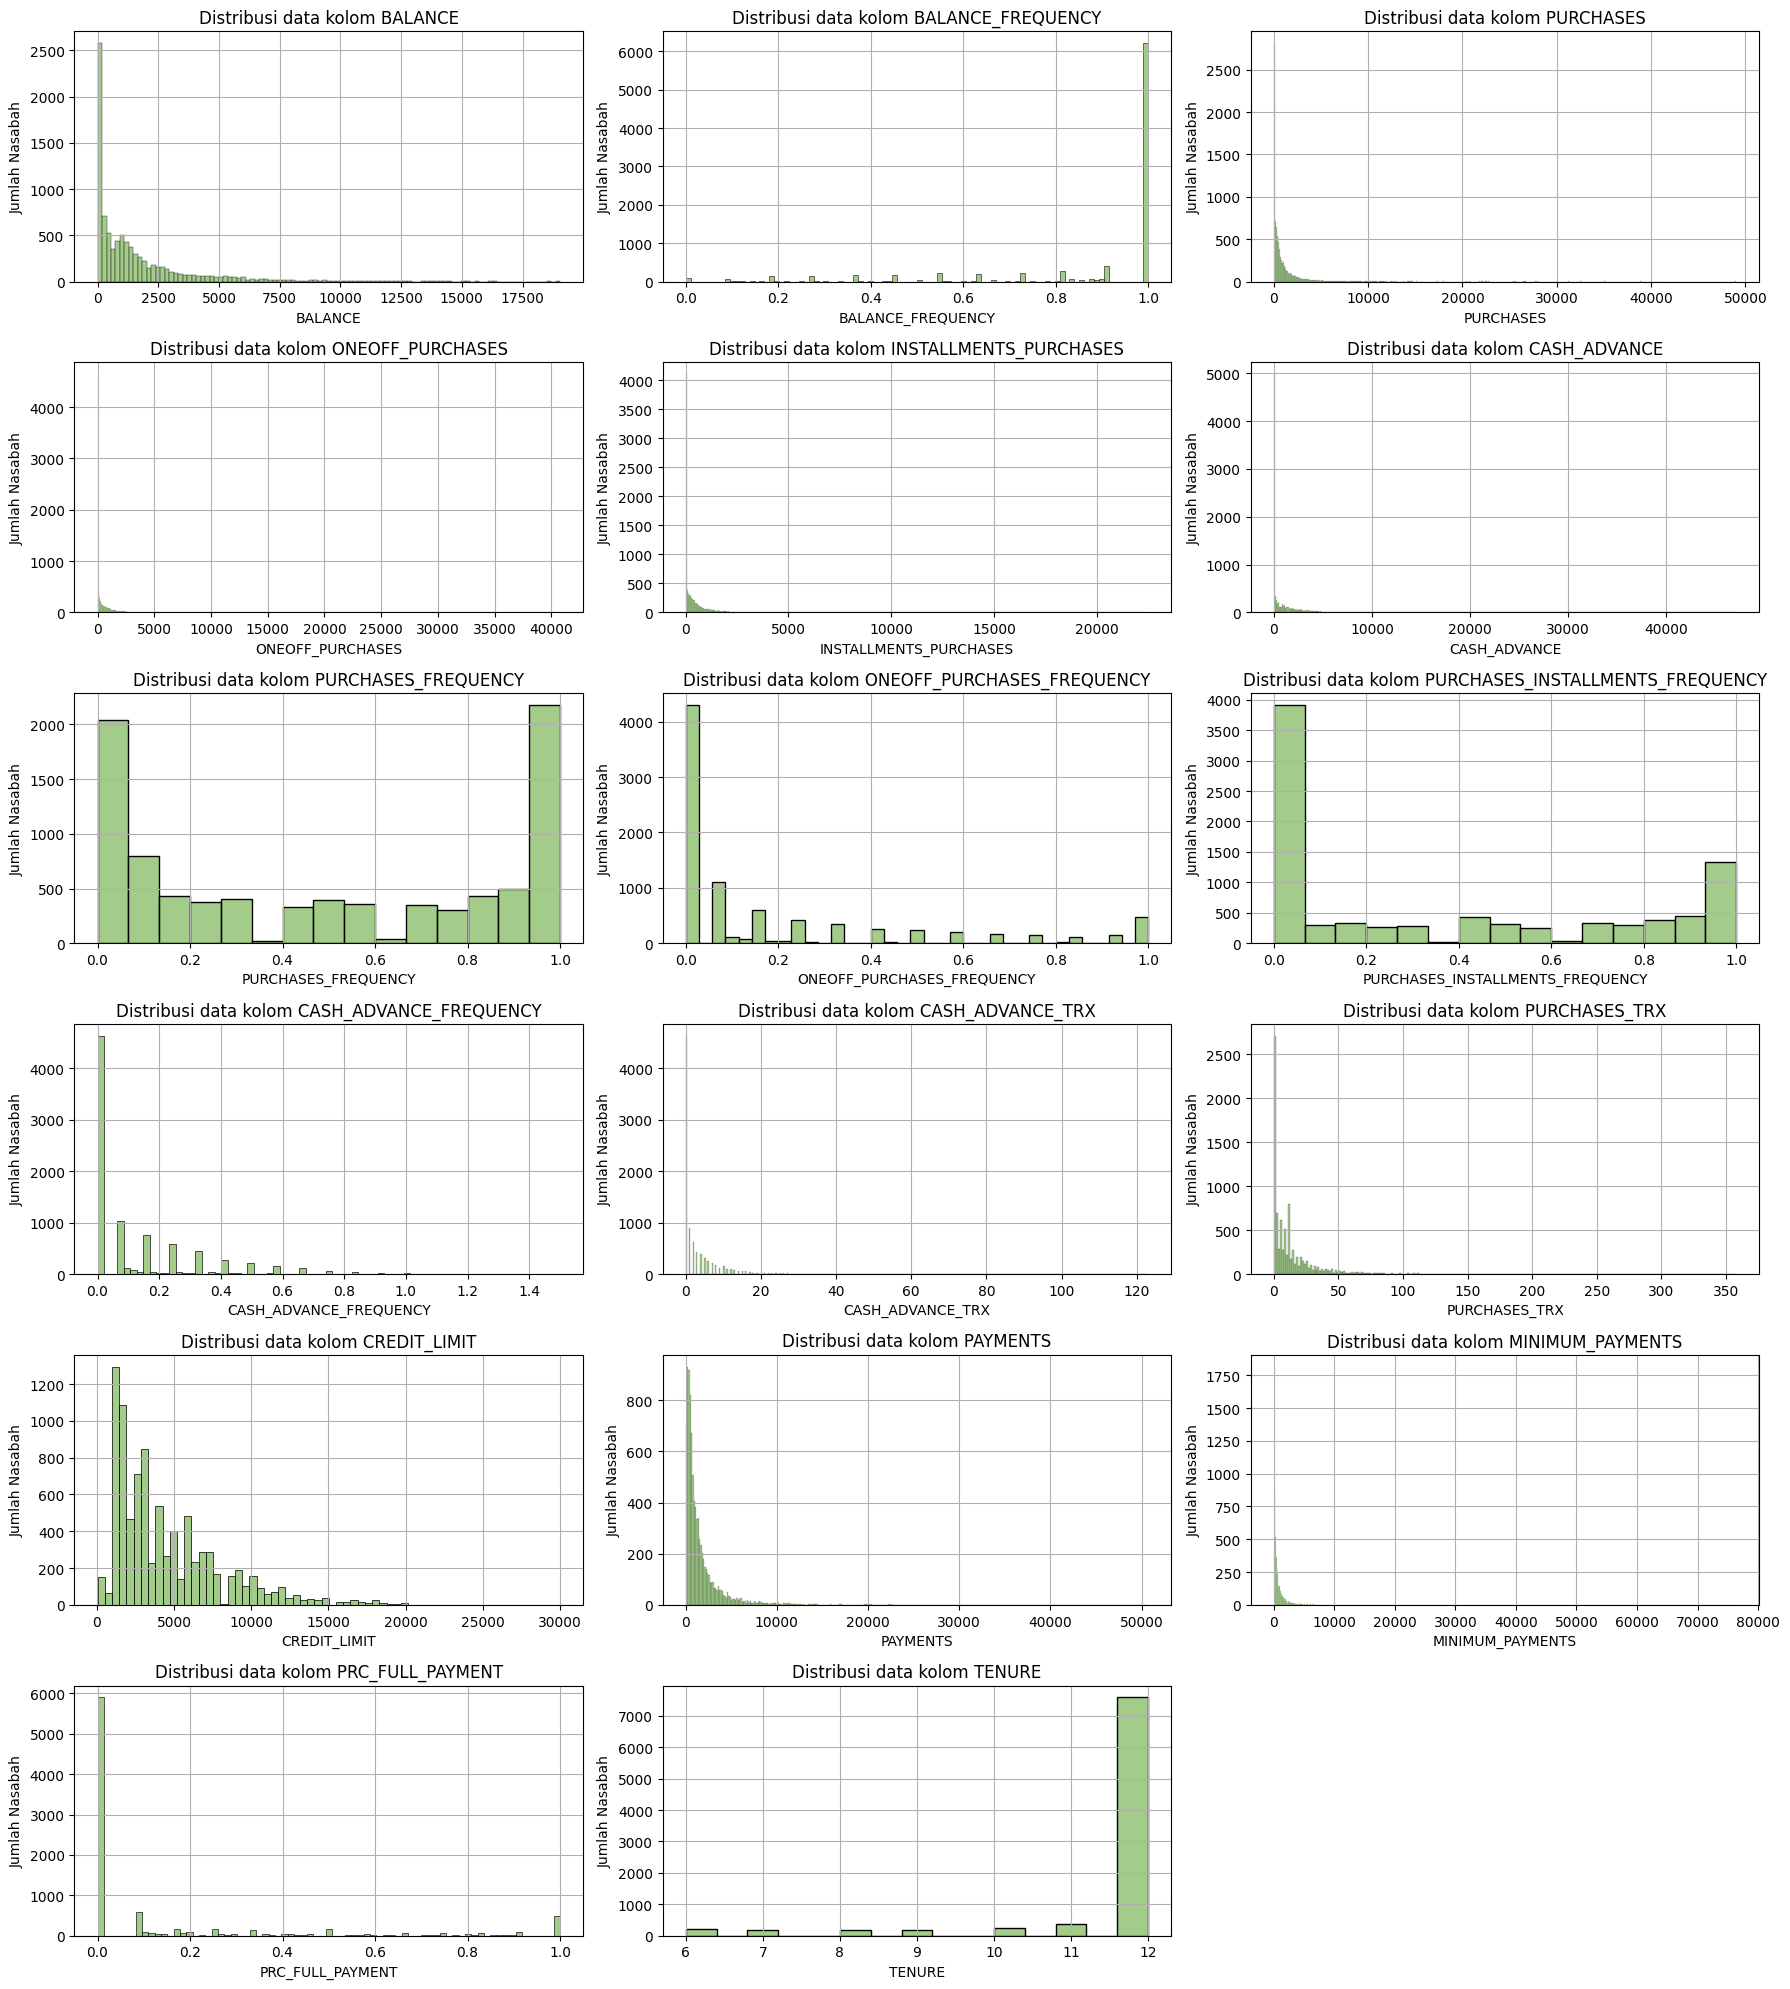

In [4]:
# plot distributi data dari semua kolom menggunakan histogram plot
count = 0
fig = plt.figure(figsize=(18, 20))
for feature in data_eda.drop(columns='CUST_ID').columns:
    count +=1
    ax = plt.subplot(6,3,count)
    sns.histplot(data=data_eda.drop(columns='CUST_ID'), x=feature, color=COLOR)
    plt.title(f"Distribusi data kolom {feature}")
    plt.ylabel("Jumlah Nasabah")
    fig.tight_layout()
    plt.grid(True)
plt.show()

**_Insight_**:
- Untuk kolom numerik yang bersifat continue, berdasarkan visualiasi di atas, terlihat jelas bahwa semua data tersebut bersifat **distribusinya tidak normal** dan memiliki sifat _right-skewed_. 
- Untuk kolom numerik yang bersifat ordinal, mayoritas nilainya adalah nol, kecuali pada kolom BALANCE_FREQUENCY, PURCHASES_FREQUENCY, dan TENURE. Pada kolom BALANCE_FREQUENCY mayoritas nilainya adalah satu, hal ini dapat terjadi karena para nasabah tersebut sering melakukan PURCHASES dan/atau PAYMENTS, sehingga BALANCE (available credit) juga akan sering ter-update. Pada kolom PURCHASES_FREQUENCY ada beberapa nasabah yang sama sekali tidak menggunakan kartu kredit (frekuensinya adalah 0), tetapi ada juga nasabah yang sering menggunakan kartu kredit (frekuensinya adalah 1). Mayoritas nasabah memilih TENURE yang 12 bulan. 
- Untuk kolom yang bersifat diskrit, pada kolom CASH_ADVANCE_TRX, jika dilihat dari jumlah nasabah, maka jumlah nasabah yang tidak melakukan pembayaran sebelum sebelum tenure kurang lebih sama dengan jumlah nasabah yang melakukan pembayaran sebelum tenure mereka. Kemudian, pada kolom PURCHASES_TRX, mayoritas nasabah telah melakukan pembelian.
- .......
- .......

Referensi: 
- [Take Control of Credit Card Debt: Current Balance vs. Available Credit](https://upgradedpoints.com/credit-cards/current-balance-vs-available-credit/)
- [Available Credit: Meaning and Examples in Credit Cards](https://www.investopedia.com/terms/a/available-credit.asp#:~:text=Available%20credit%20refers%20to%20how,payments%20increase%20your%20available%20credit.)

In [5]:
# Cek menggunakan metode statistik shapiro test sebagai validasi apakah memang betul distribusinya tidak normal untuk data numerik yang bersifat continue

# kolom numerik yang bersifat continue
num_continue = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS']

# melakukan shapiro test
result_shapiro = []
for cols in num_continue:
    # pvalue selain kolom MINIMUM_PAYMENTS
    if cols not in ['MINIMUM_PAYMENTS', 'CREDIT_LIMIT']:
        stats, pvalue = shapiro(data_eda[cols])
        # check nilai p-value
        if pvalue > 0.05:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data normal'})
        else:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data tidak normal'})
    
    # pvalau kolom MINIMUM_PAYMENTS (terdapat nilai NaN, nilai p-value akan bias jika NaN values tidak dihapus)
    else:
        stats, pvalue = shapiro(data_eda[cols].dropna())
        # check nilai p-value
        if pvalue > 0.05:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data normal'})
        else:
            result_shapiro.append({'kolom':cols, 'pvalue':pvalue, 'jenis_distribusi':'distribusi data tidak normal'})
    

# display hasil uji statistik
shapiro_df = pd.DataFrame(result_shapiro)
shapiro_df

kolom  pvalue              jenis_distribusi
0                 BALANCE     0.0  distribusi data tidak normal
1               PURCHASES     0.0  distribusi data tidak normal
2        ONEOFF_PURCHASES     0.0  distribusi data tidak normal
3  INSTALLMENTS_PURCHASES     0.0  distribusi data tidak normal
4            CASH_ADVANCE     0.0  distribusi data tidak normal
5            CREDIT_LIMIT     0.0  distribusi data tidak normal
6                PAYMENTS     0.0  distribusi data tidak normal
7        MINIMUM_PAYMENTS     0.0  distribusi data tidak normal

**_Insight_**:
- Setelah melakukan **uji normalitas dengan metode shapiro**, terbukti bahwa semua kolom numerik yang bersifat continue distribusi datanya tidak normal karena memiliki nilai p-value kurang dari 0.05
- Cek korelasi antar kolom akan dilakukan dengan metode Spearman (non-parametric method)

### 2. Hubungan Antar Kolom

1. Plot persebaran data antara kolom satu dengan kolom lainnya menggunakan metode scatter plot
2. Melakukan cek korelasi data antar kolom menggunakan metode Spearman
3. Melihat bagaimana hubungan antar kolom

#### 2.1. Persebaran Data Menggunakan Scatter Plot

> 2.1.1 **PURCHASES**

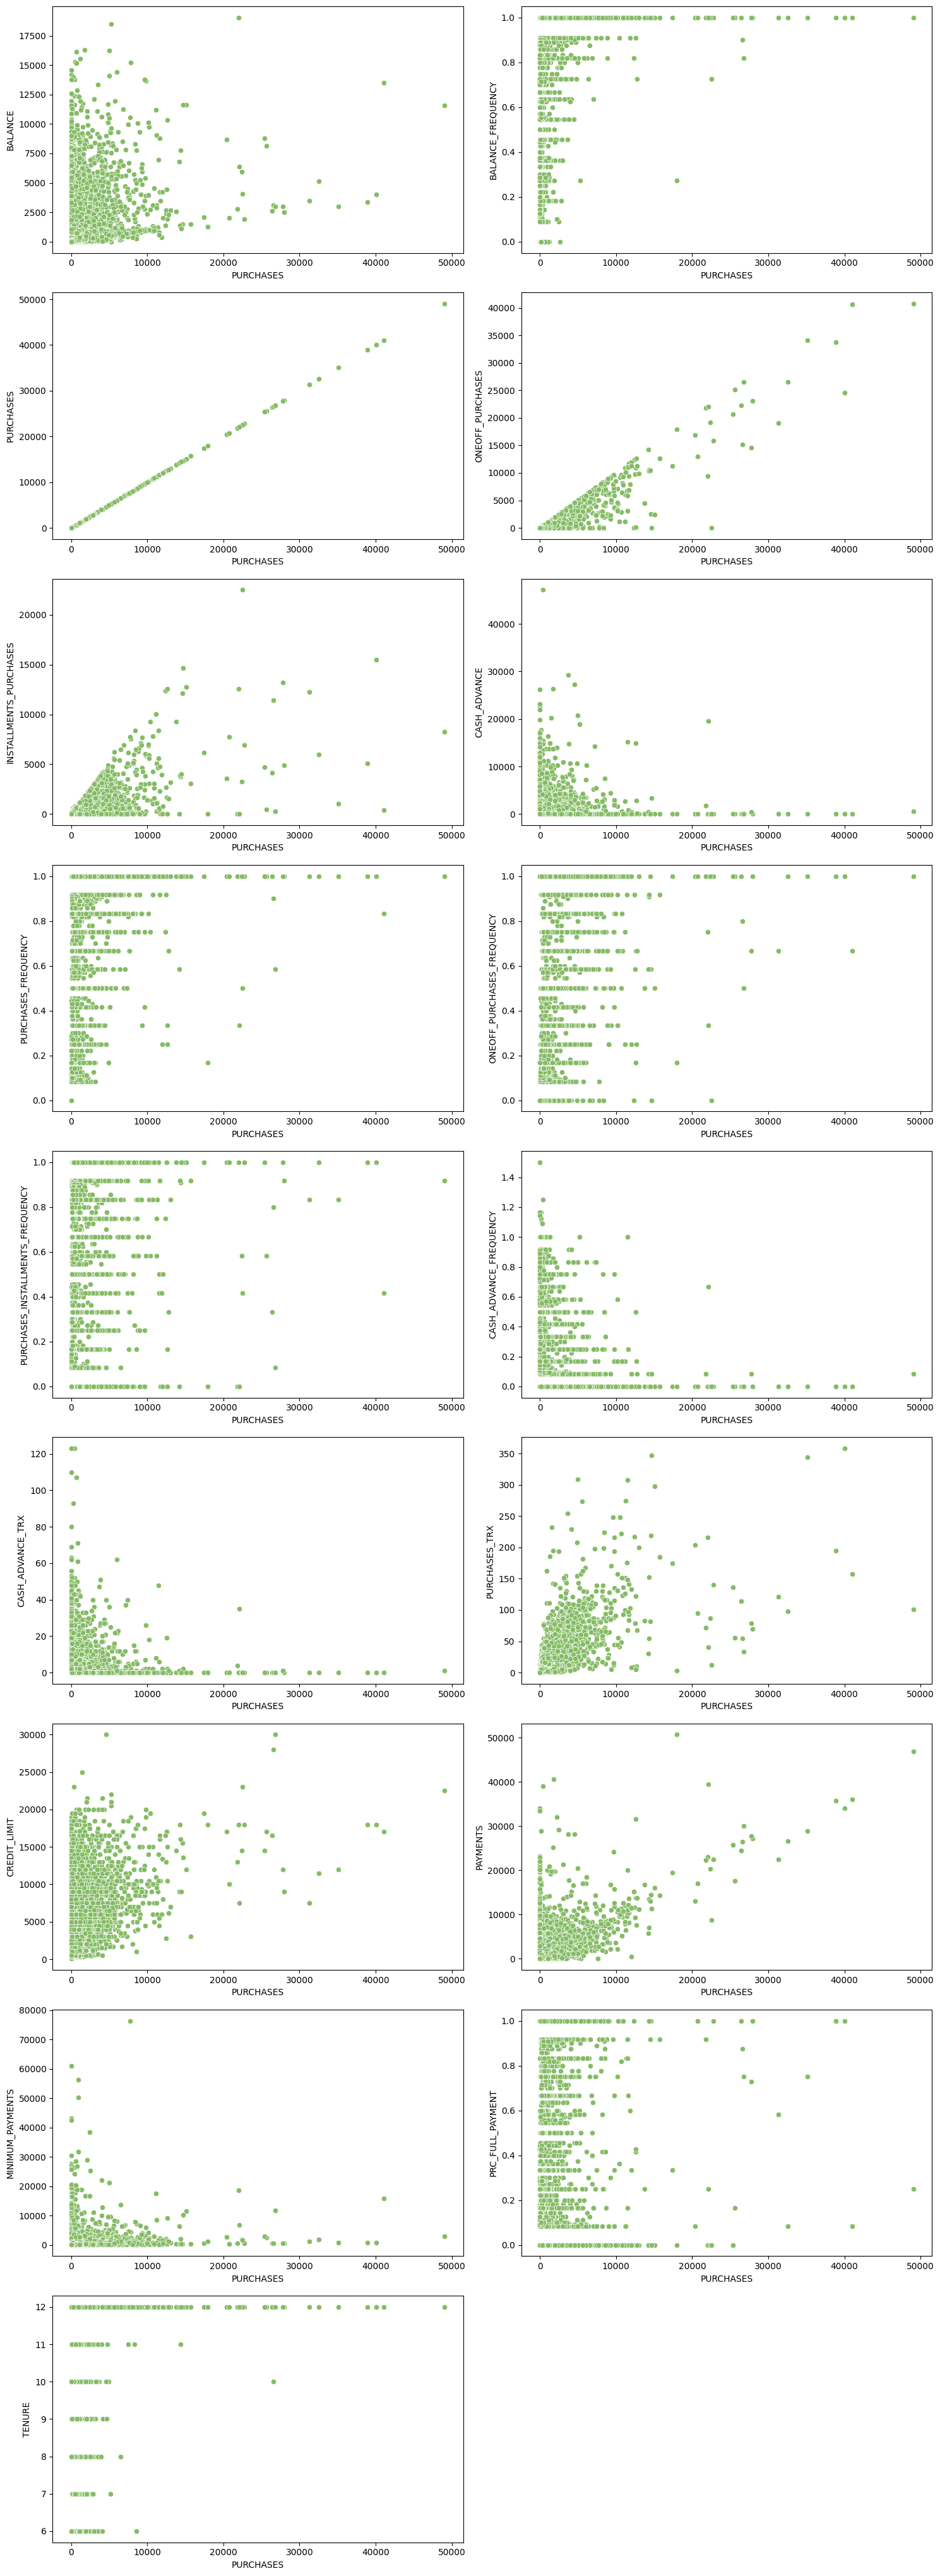

In [11]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["PURCHASES"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

> 2.1.2 **BALANCE**

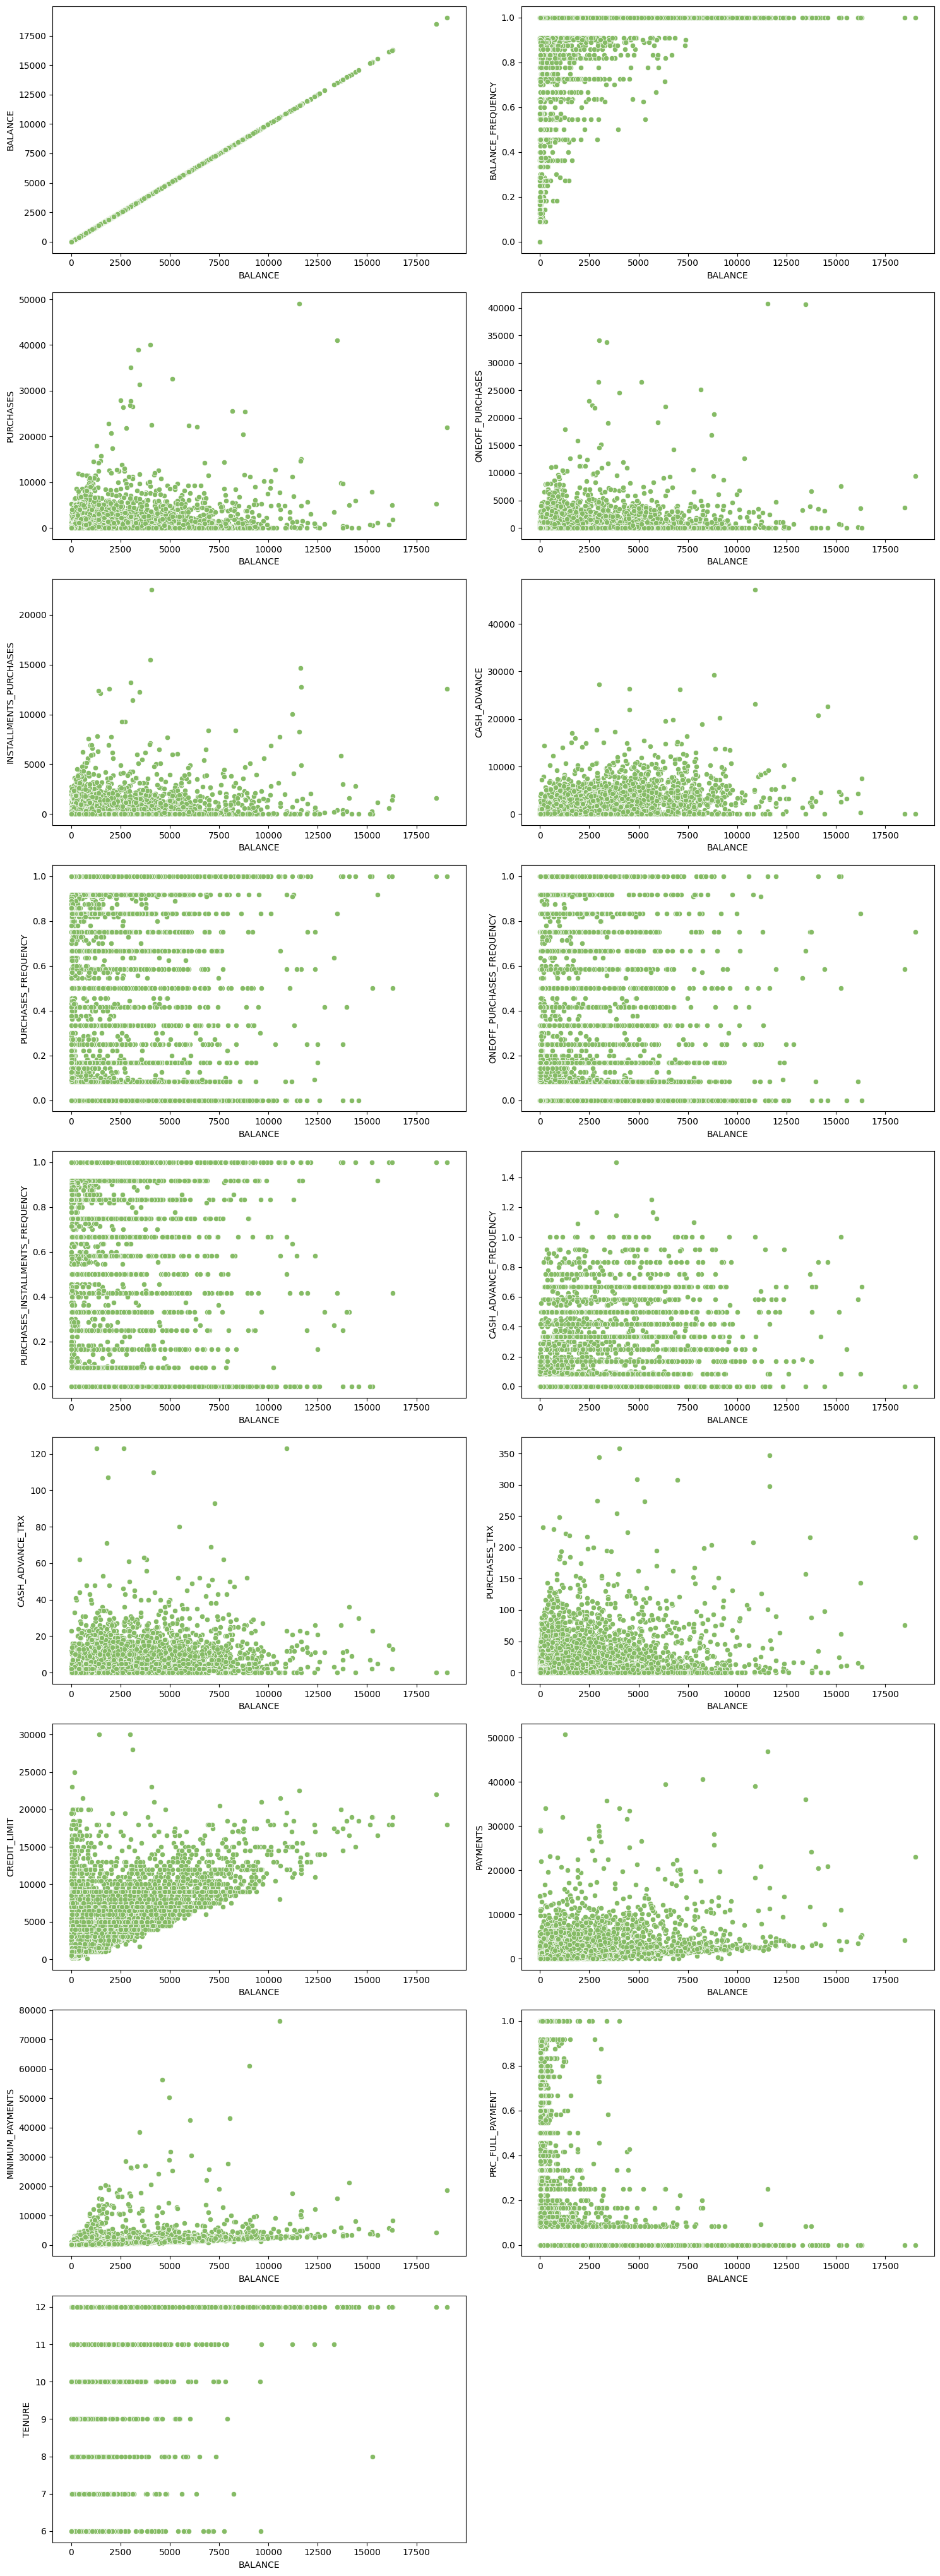

In [12]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["BALANCE"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

> 2.1.3 **CREDIT_LIMIT**

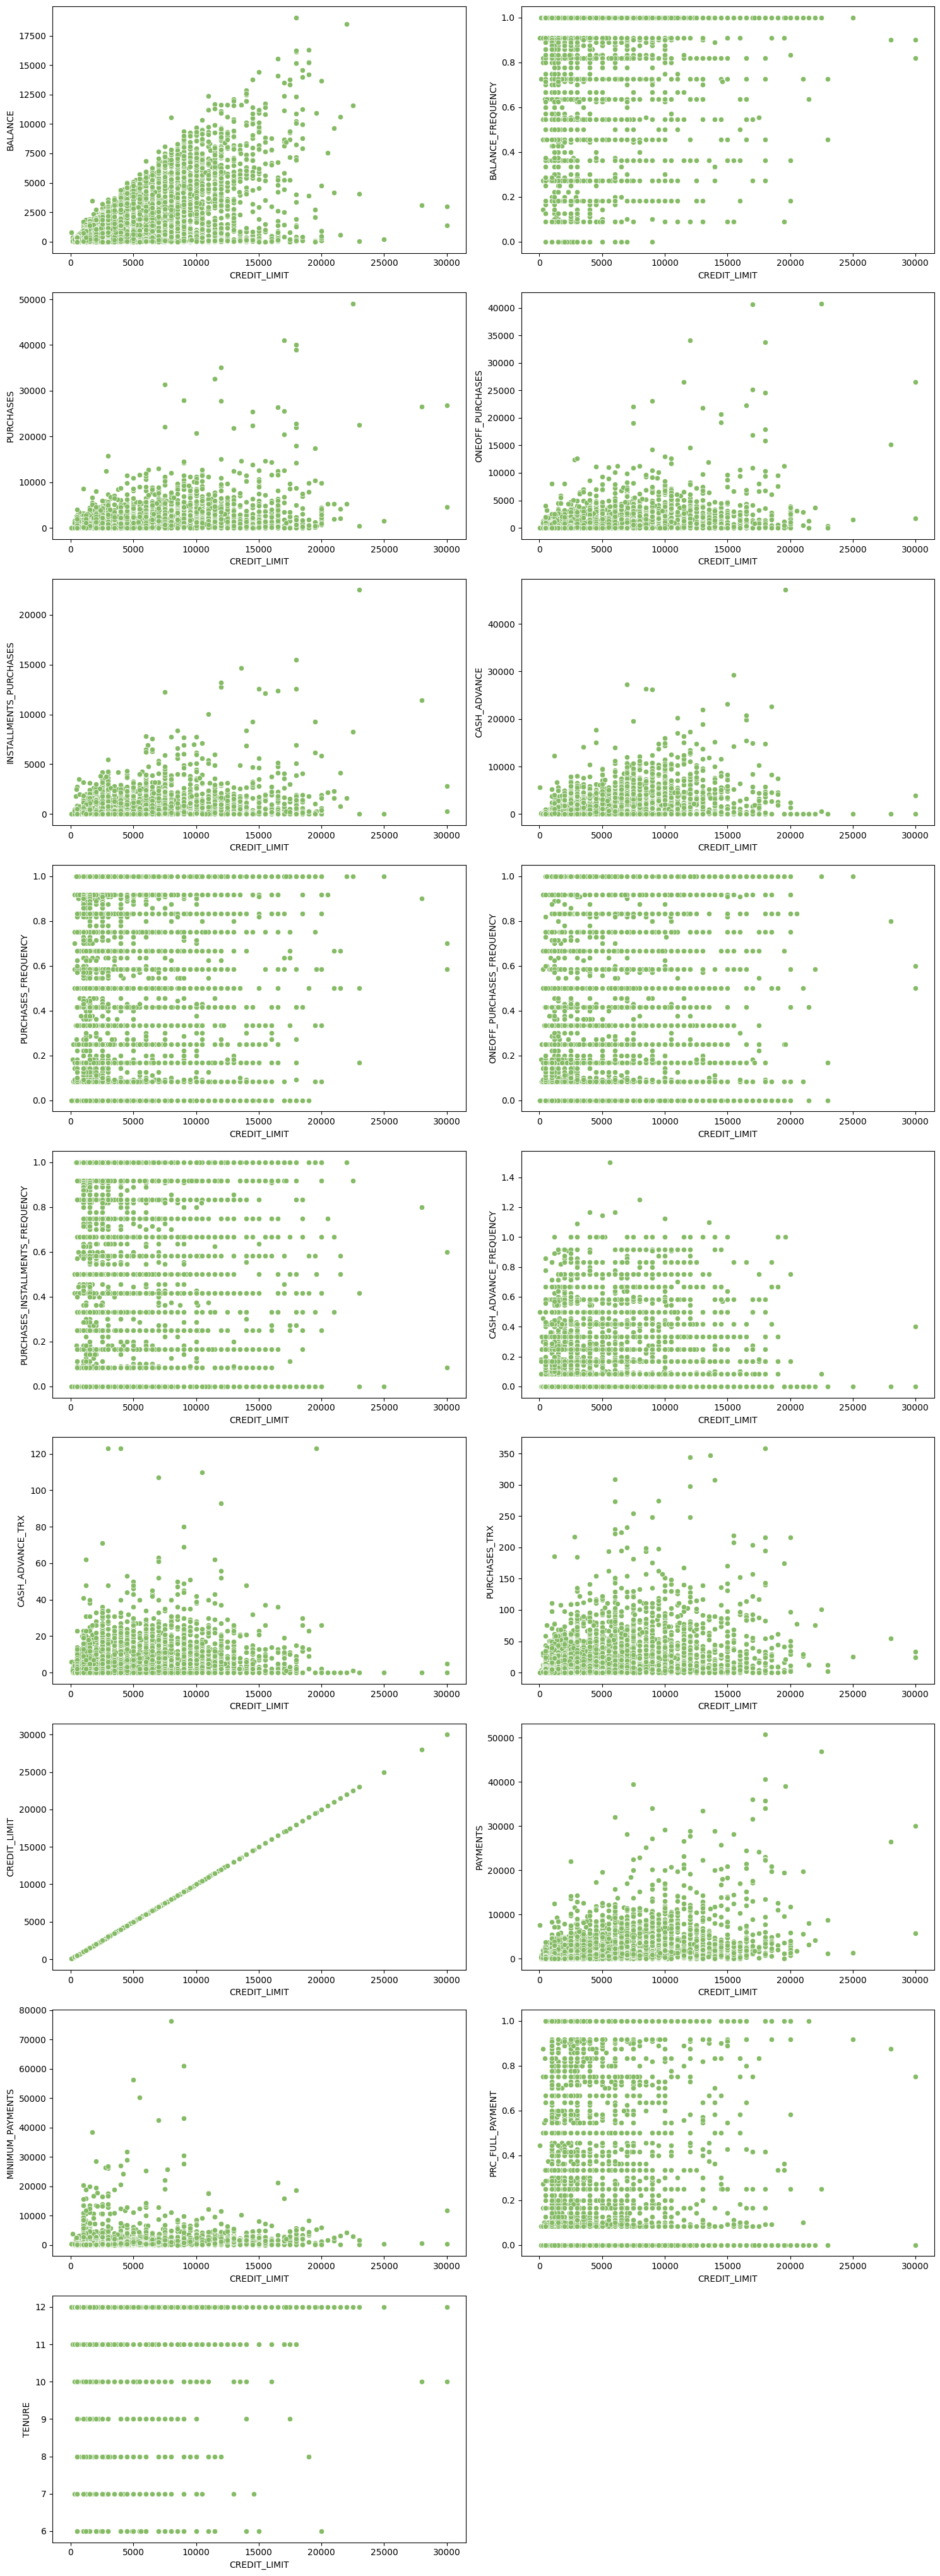

In [13]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["CREDIT_LIMIT"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

> 2.1.4 **ONEOFF_PURCHASES**

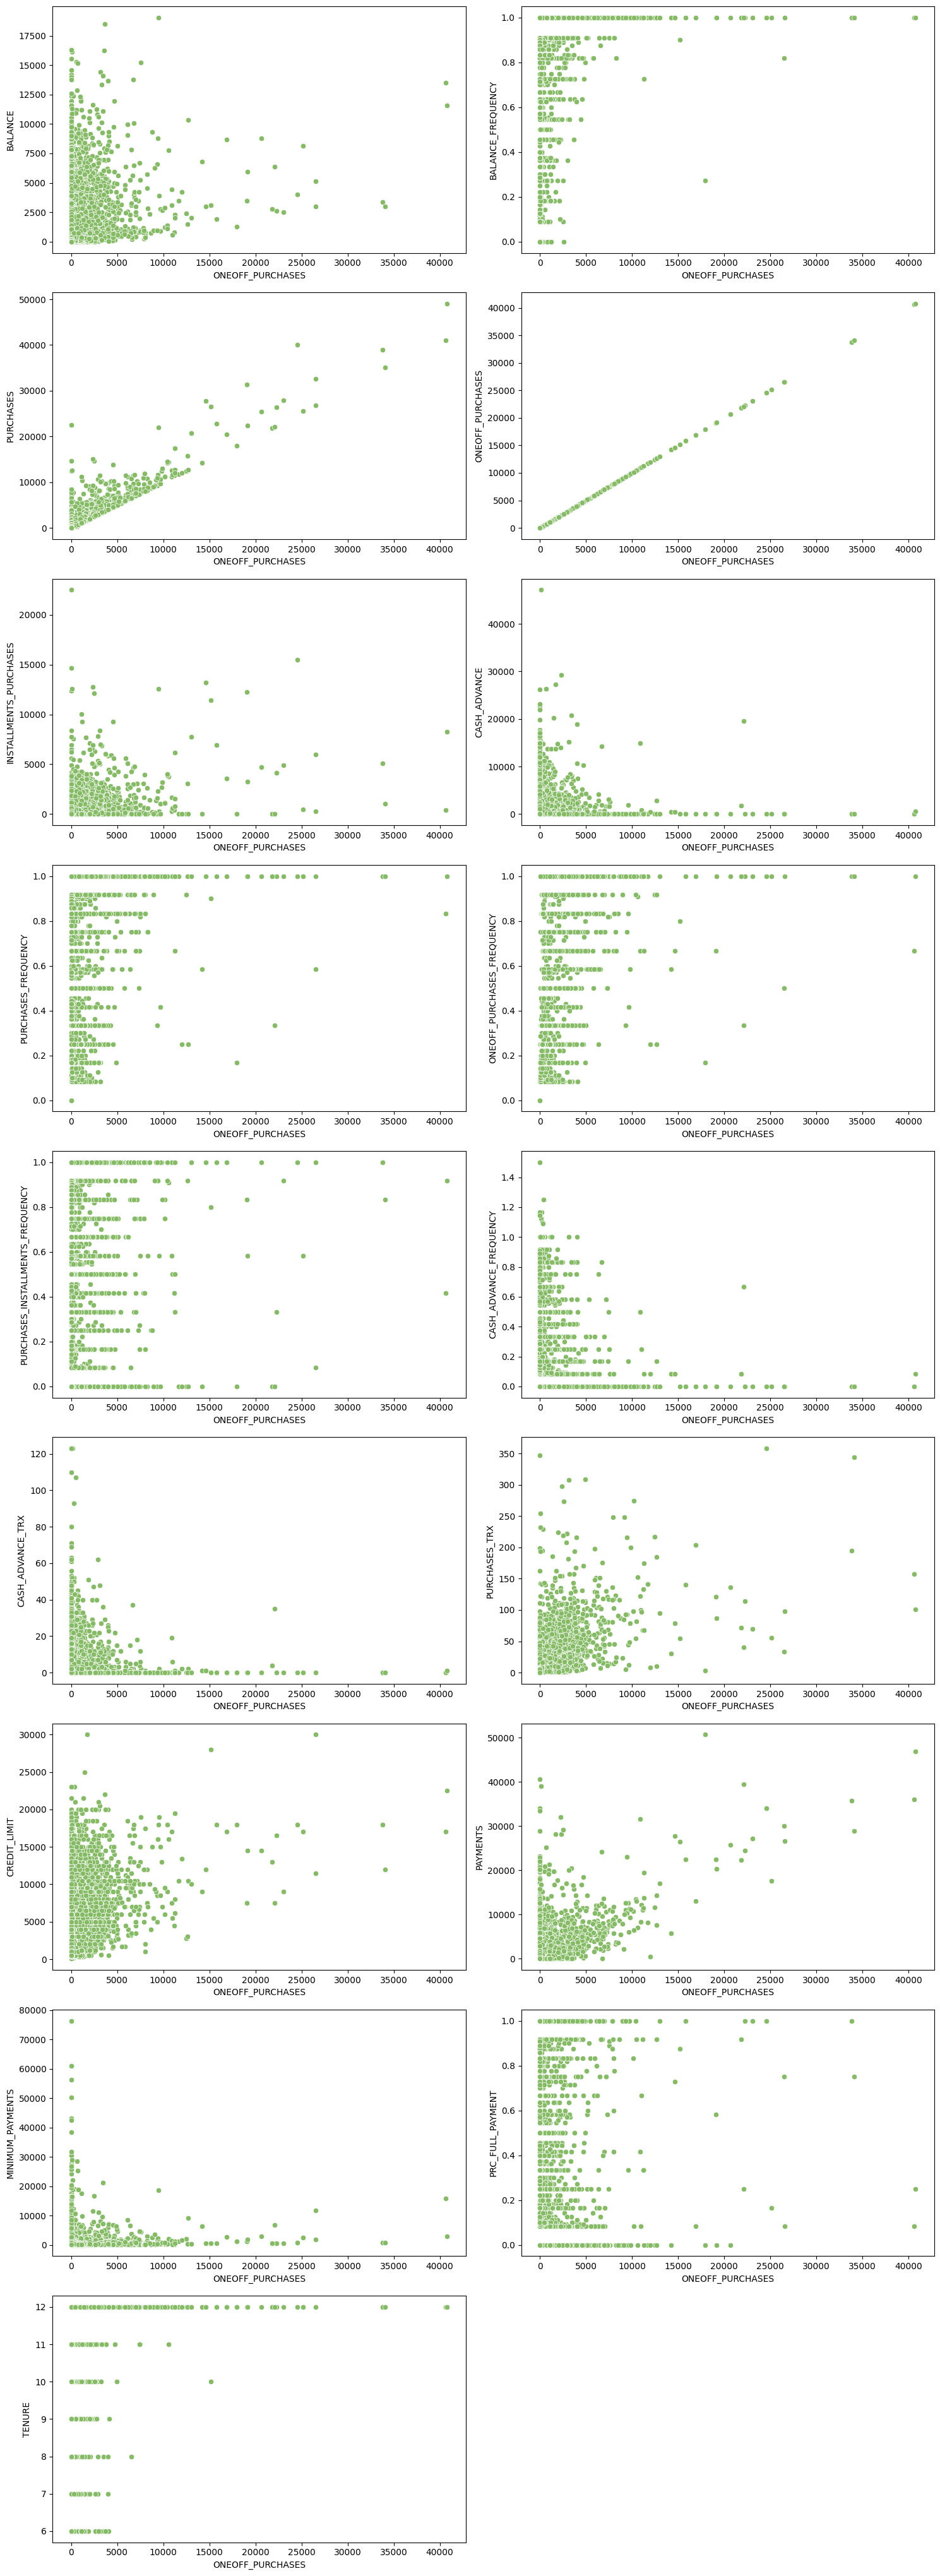

In [15]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["ONEOFF_PURCHASES"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

> 2.1.5 **INSTALLMENTS_PURCHASES**

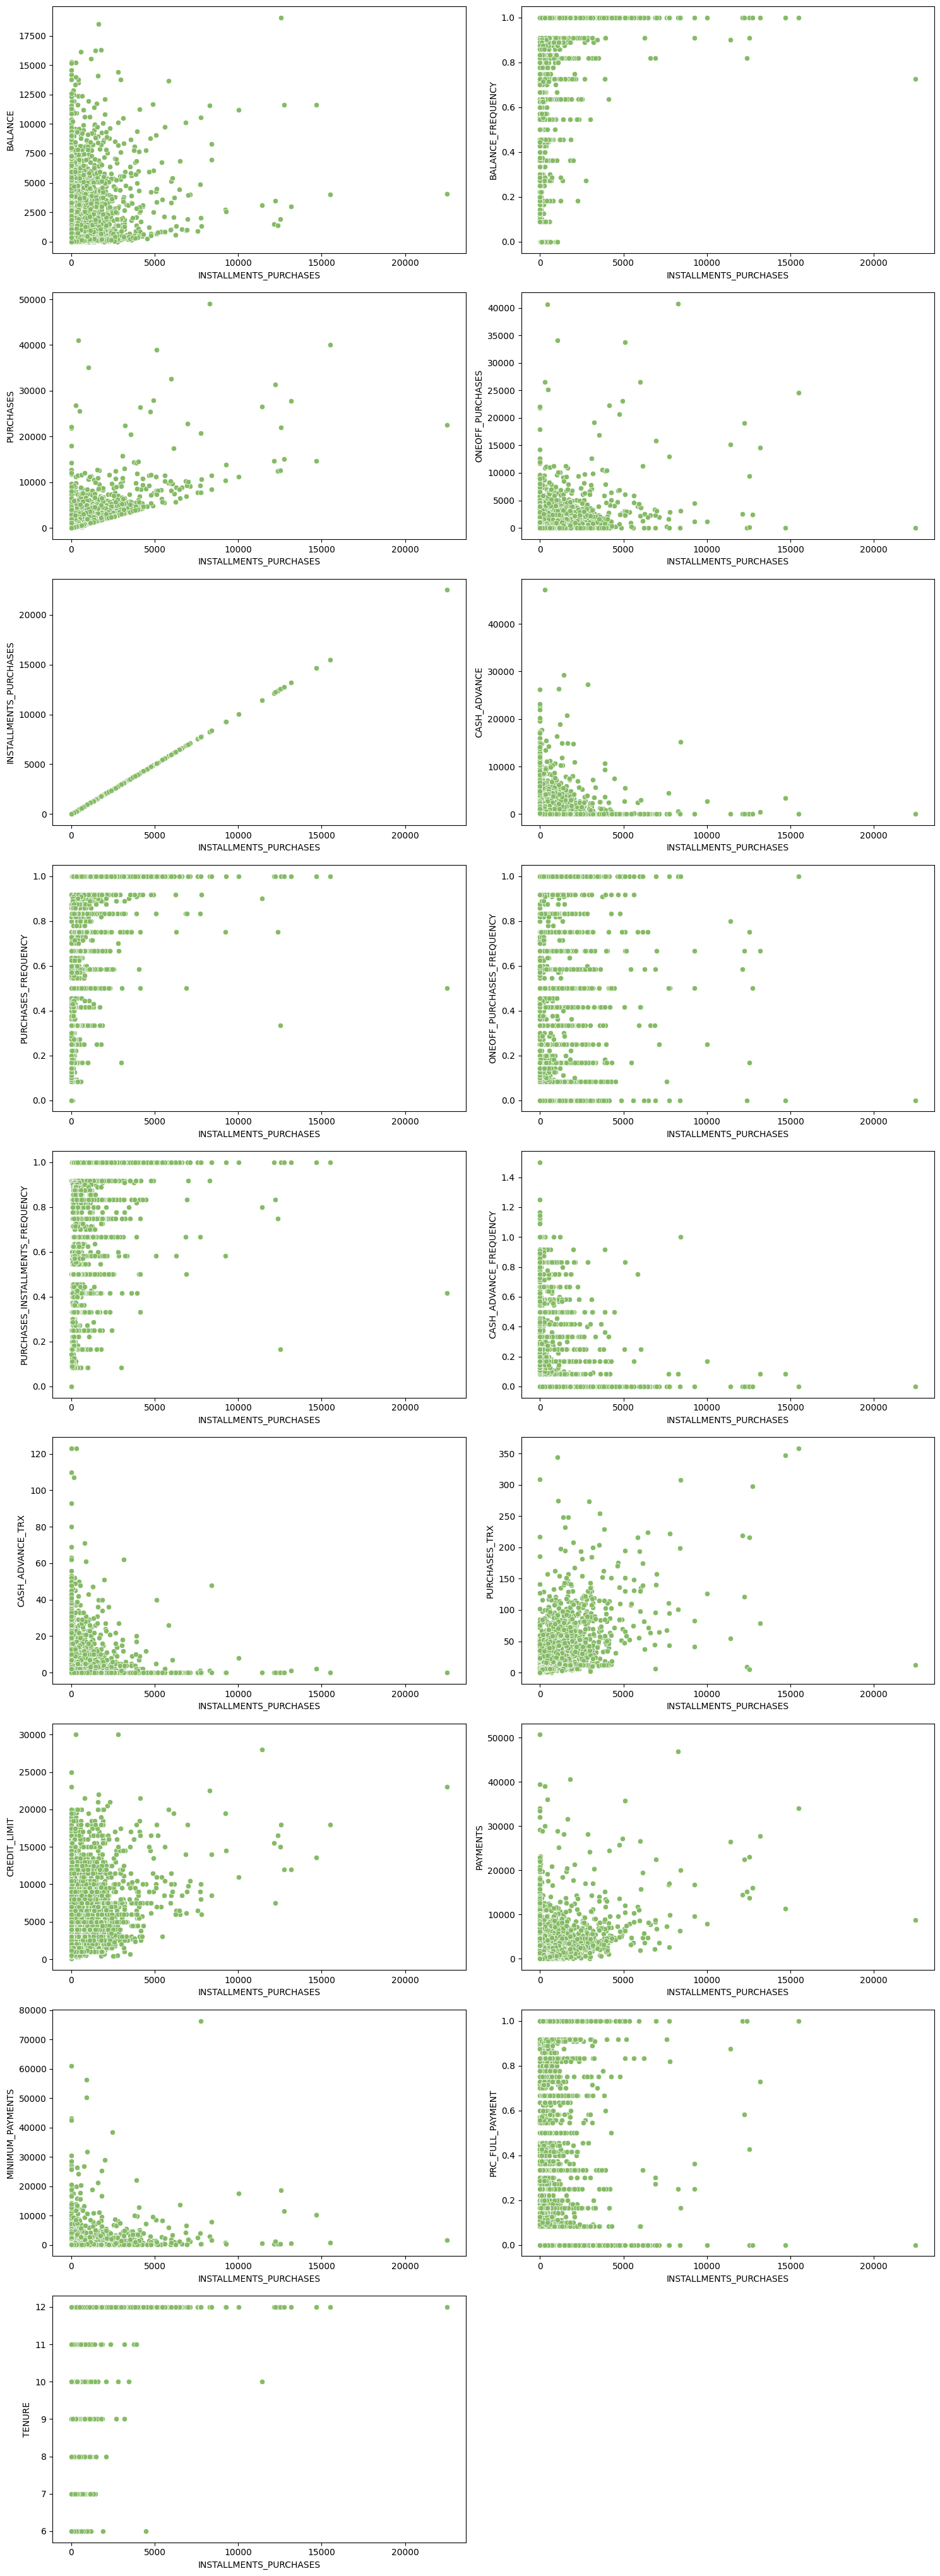

In [16]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["INSTALLMENTS_PURCHASES"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

> 2.1.6 **CASH_ADVANCE**

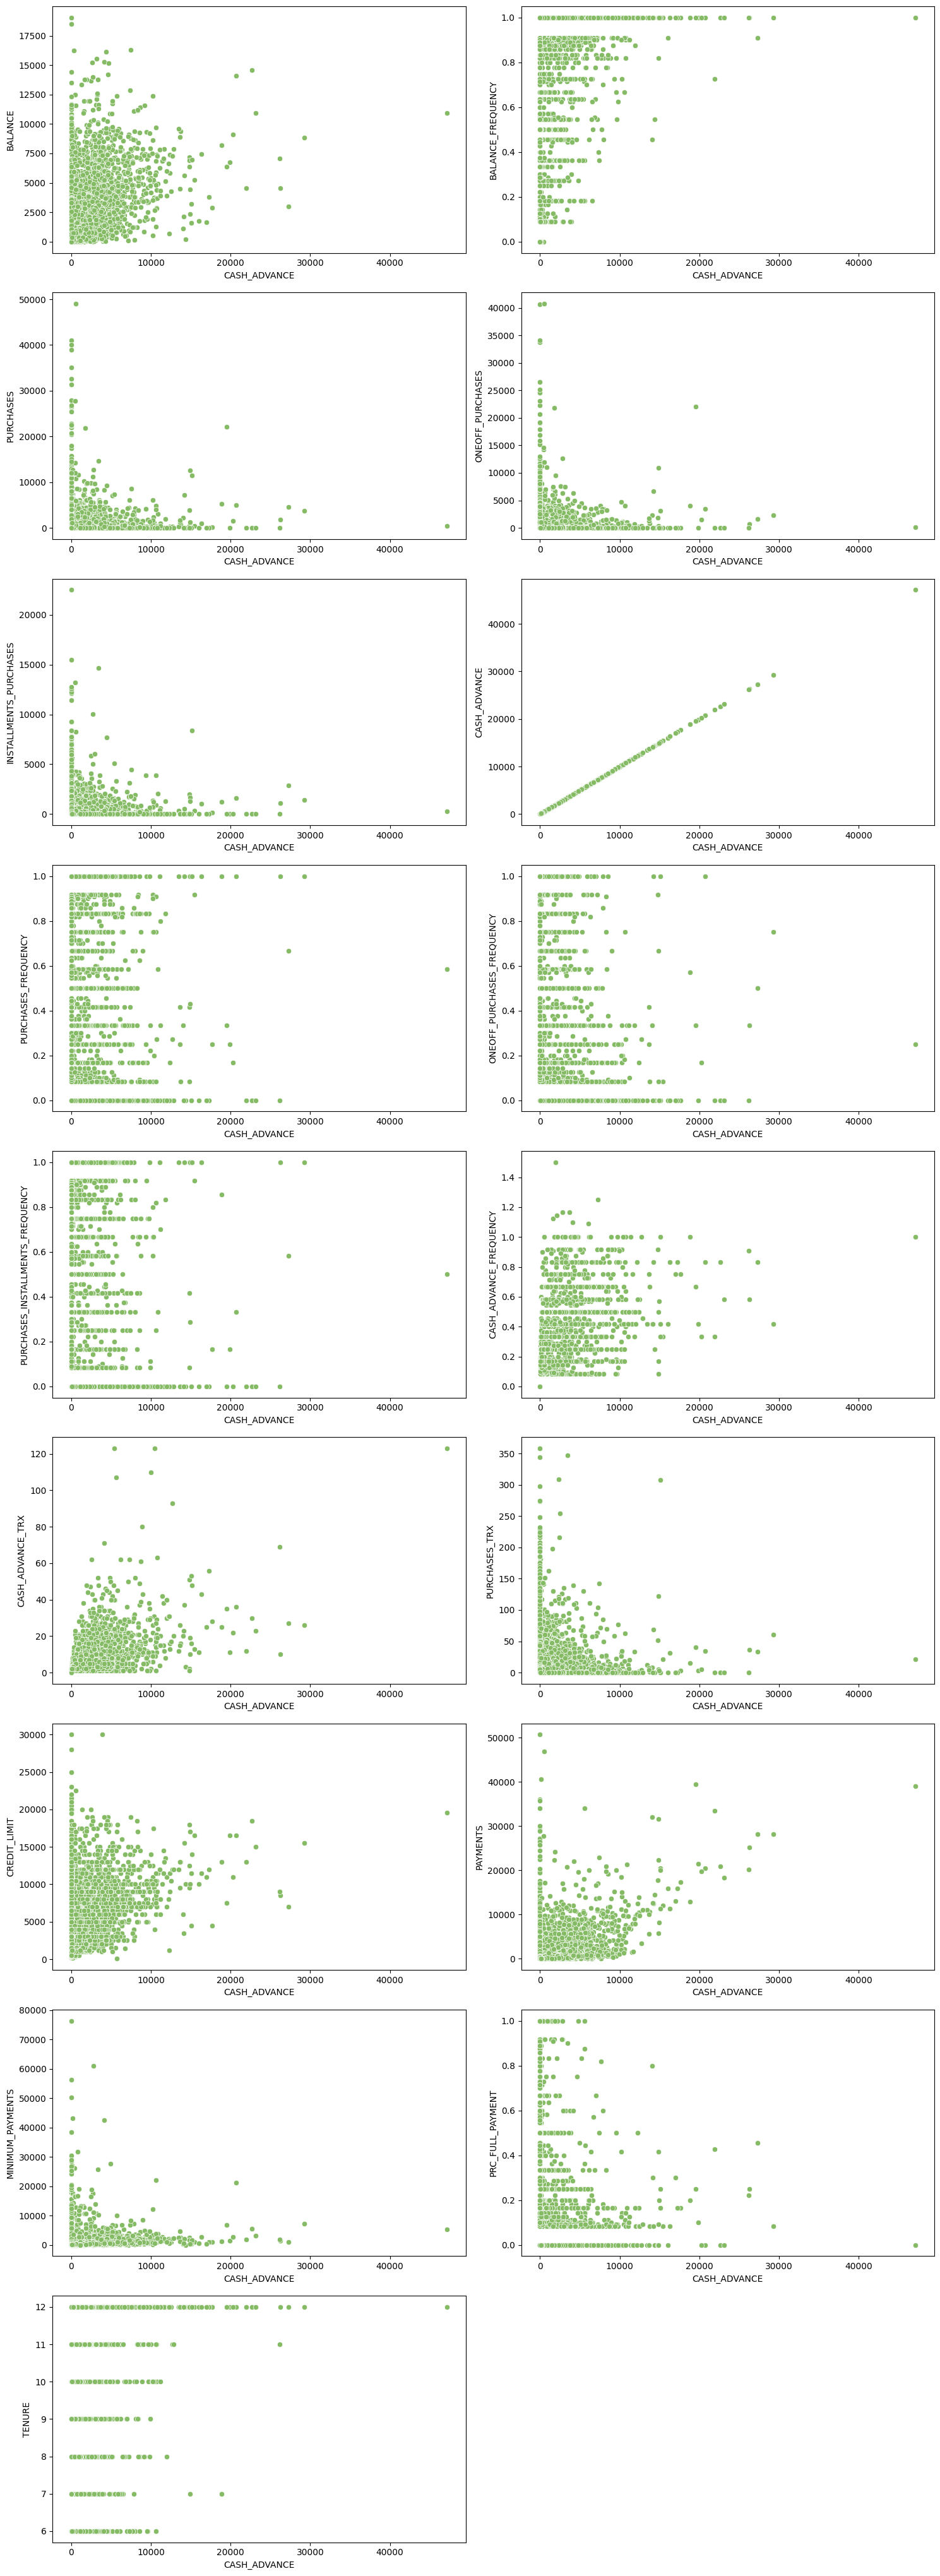

In [17]:
count=0
fig = plt.figure(figsize=(15, 45))
data_scater = data.drop(columns='CUST_ID')
for feature in data_scater.columns:
    count +=1
    ax= plt.subplot(10,2,count)
    sns.scatterplot(x=data["CASH_ADVANCE"], y=data[feature], c=COLOR)
    fig.tight_layout()
plt.show()

**_Insight_**:
- Terdapat beberapa kolom yang persebaran datanya memiliki sifat cenderung **linear**, misalnya antara kolom ONEOFF_PURCHASES dengan kolom PURCHASES, kolom INSTALLMENT_PURCHASES dengan kolom PURCHASES. dsb. Namun banyak juga kolom yang persebaran datanya memiliki sifat **non-linear**, misalnya antara kolom CREDIT_LIMIT dengan kolom-kolom yang merupakan frekuensi (PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, dsb)
- Terdapat beberapa data yang sifatnya _bivariate outlier_. Misalnya, antara kolom PURCHASES dengan kolom BALANCE, ada nasabah yang total pembeliannya besar, tapi sisa saldo kartu kredit yang masih bisa digunakan juga besar. Hal ini dapat terjadi karena PURCHASES dilakukan secara ONEOFF_PURCHASES (tagihannya langsung dibayarkan (lunas))
- .......
- .......

#### 2.2. Cek Korelasi Data Antar Kolom Menggunakan Metode Spearman

**Output nilai korelasi** yang dihasilkan adalah nilai antara -1 sampai 1. Jika nilai data pada variabel/kolom "A" **bertambah**, begitu pula pada variabel/kolom "B", maka nilai output yang dihasilkan akan semakin **mendekati 1 (positif) atau berkorelasi tinggi**, sedangkan jika yang terjadi adalah **sebaliknya (berkurang)**, maka nilai output yang dihasilkan akan semakin **mendekati -1 (negatif) atau berkorelasi tinggi, namun arahnya negatif**. Kemudian, jika nilai output yang dihasilkan **mendekati 0**, hal ini berarti data pada variabel/kolom "A" **tidak memiliki korelasi** dengan data pada variabel/kolom "B"

Selanjutnya, dari nilai korelasi antar kolom tersebut akan diuji secara statistik apakah memang benar kedua kolom tersebut memiliki korelasi atau tidak. Jika nilai **_pvalue_ kurang dari _significance level_ 0.05**, maka kedua kolom tersebut **memiliki korelasi**. Sebaliknya, jika nilai **_pvalue_ lebih besar dari significance level 0.05**, maka kedua kolom tersebut **tidak memiliki korelasi**.

Hipotesis:
- H0 : nilai korelasi kedua kolom tersebut = 0 (Tidak memiliki korelasi)
- H1 : nila korelasi kedua kolom tersebut ≠ 0 (Memiliki korelasi)

significance level (alpha) = 0.05

Note: untuk memudahkan dalam interpretasi, hasil hipotesis akan diplot ke dalam grafik heatmap, jika nilai pada **_heatmap_ sama dengan 1**, maka kedua kolom tersebut **memiliki korelasi**, sedangkan jika nilai pada **_heatmap_ sama dengan 0**, maka kedua kolom tersebut **tidak memiliki korelasi**.

Referensi:
- [Spearman's rank correlation coefficient (wikipedia)](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient#:~:text=The%20sign%20of,coefficient%20becomes%201.)
- [Spearman's rank correlation coefficient (datatab)](https://datatab.net/tutorial/spearman-correlation)
- [scipy stats spearmanr documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html#:~:text=The%20p%2Dvalue%20for%20a%20hypothesis%20test%20whose%20null%20hypothesis%20is%20that%20two%20samples%20have%20no%20ordinal%20correlation.%20See%20alternative%20above%20for%20alternative%20hypotheses.%20pvalue%20has%20the%20same%20shape%20as%20statistic.)

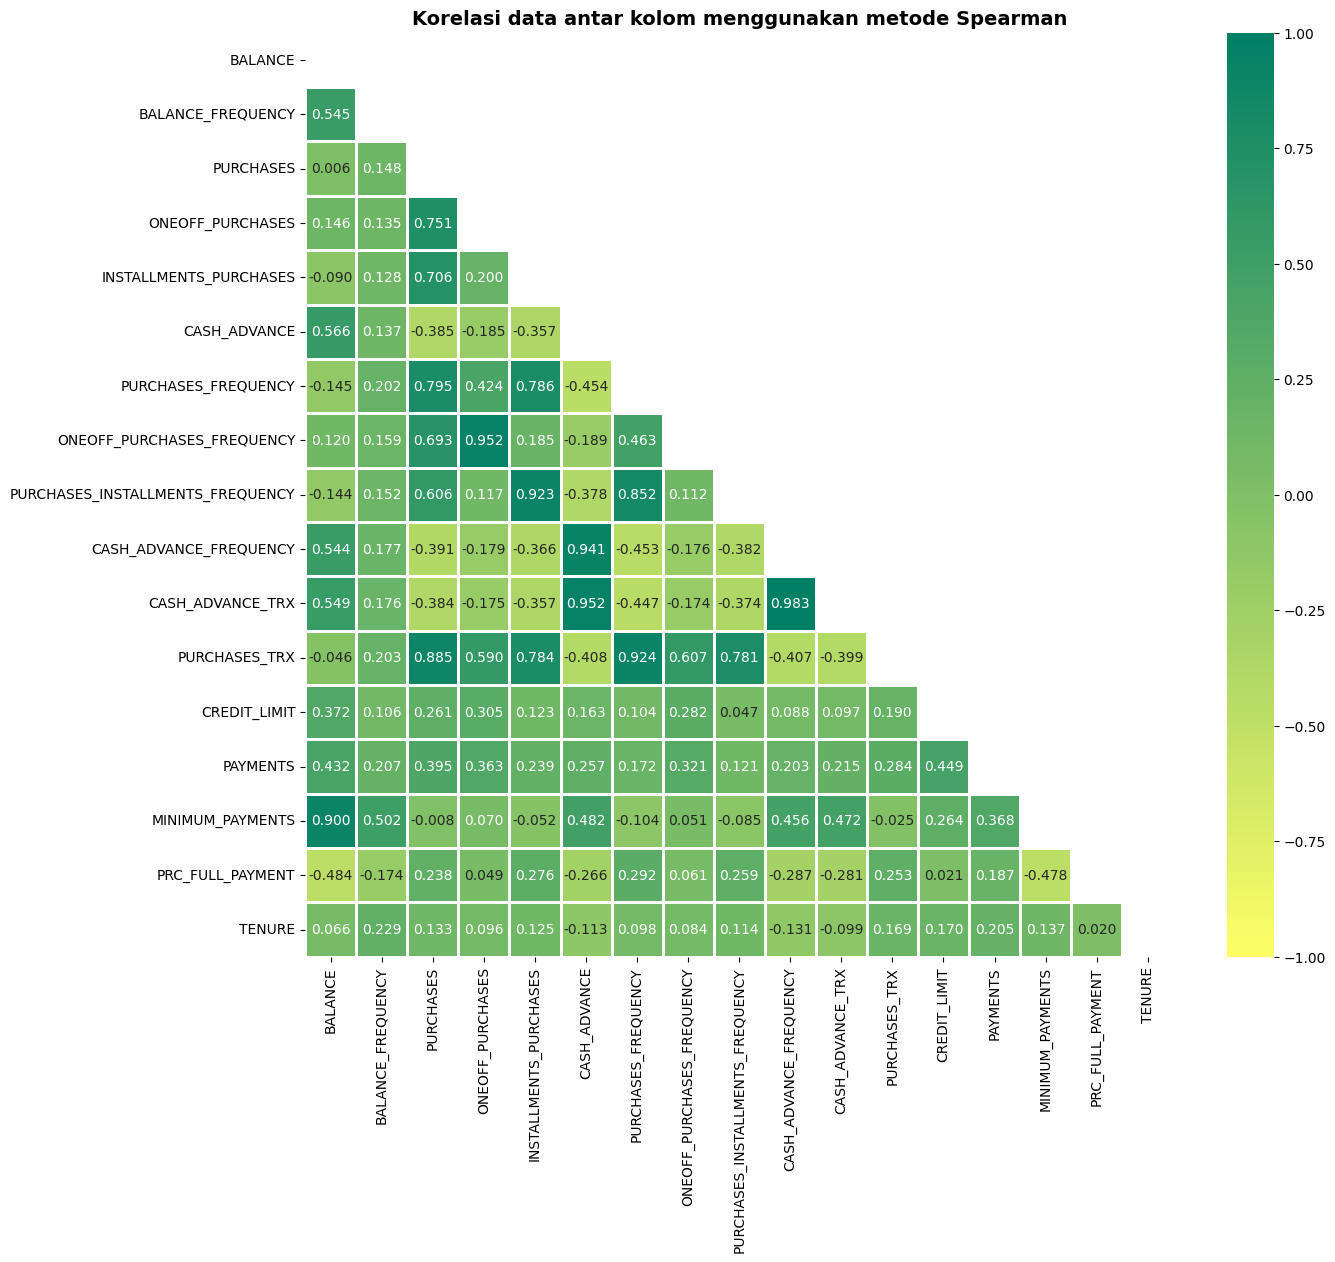

In [ ]:
# cek korelasi data antar kolom menggunakan metode Spearman

# data nilai korelasi
matrix = np.triu(data_eda.drop(columns='CUST_ID').corr(method='spearman'))
# color map
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# plot data nilai korelasi menggunakan grafik heatmap
plt.figure(figsize=(14,12))
plt.title("Korelasi data antar kolom menggunakan metode Spearman", size=14, fontdict={'weight':'heavy'})
sns.heatmap(data=data_eda.corr(method='spearman'), annot=True, fmt=".3f", cmap=CUSTOM_SUMMER, vmin=-1, vmax=1, mask=matrix, linewidths=2);

**_Insight_**:
- Terdapat beberapa pola yang memiliki kecenderungan yang sama, yaitu data yang berupa frekuensi atau jumlah transaksi memiliki nilai korelasi positif yang tinggi dengan data yang berkaitan dengan data itu sendiri. Contohnya dapat dilihat pada kolom CASH_ADVANCE_FREQUENCY berkorelasi tinggi (0.941) dengan kolom CASH_ADVANCE dan juga dengan kolom CASH_ADVANCE_TRX (0.983), kolom PURCHASES_FREQUENCY berkorelasi tinggi (0.795) dengan kolom PURCHASES dan juga dengan kolom PURCHASES_TRX (0.924), dsb.
- Terdapat juga nilai korelasi negatif yang sedikit cenderung linear, misalnya antara kolom PRC_FULL_PAYMENT dengan kolom MINIMUM_PAYMENTS (-0.478). Hal menunjukkan pola ada beberapa customer yang melakukan pembayaran (payment) yang nilainya semakin besar, tapi total presentase yang disudah dibayarkan semakin kecil.
- .......
- .......

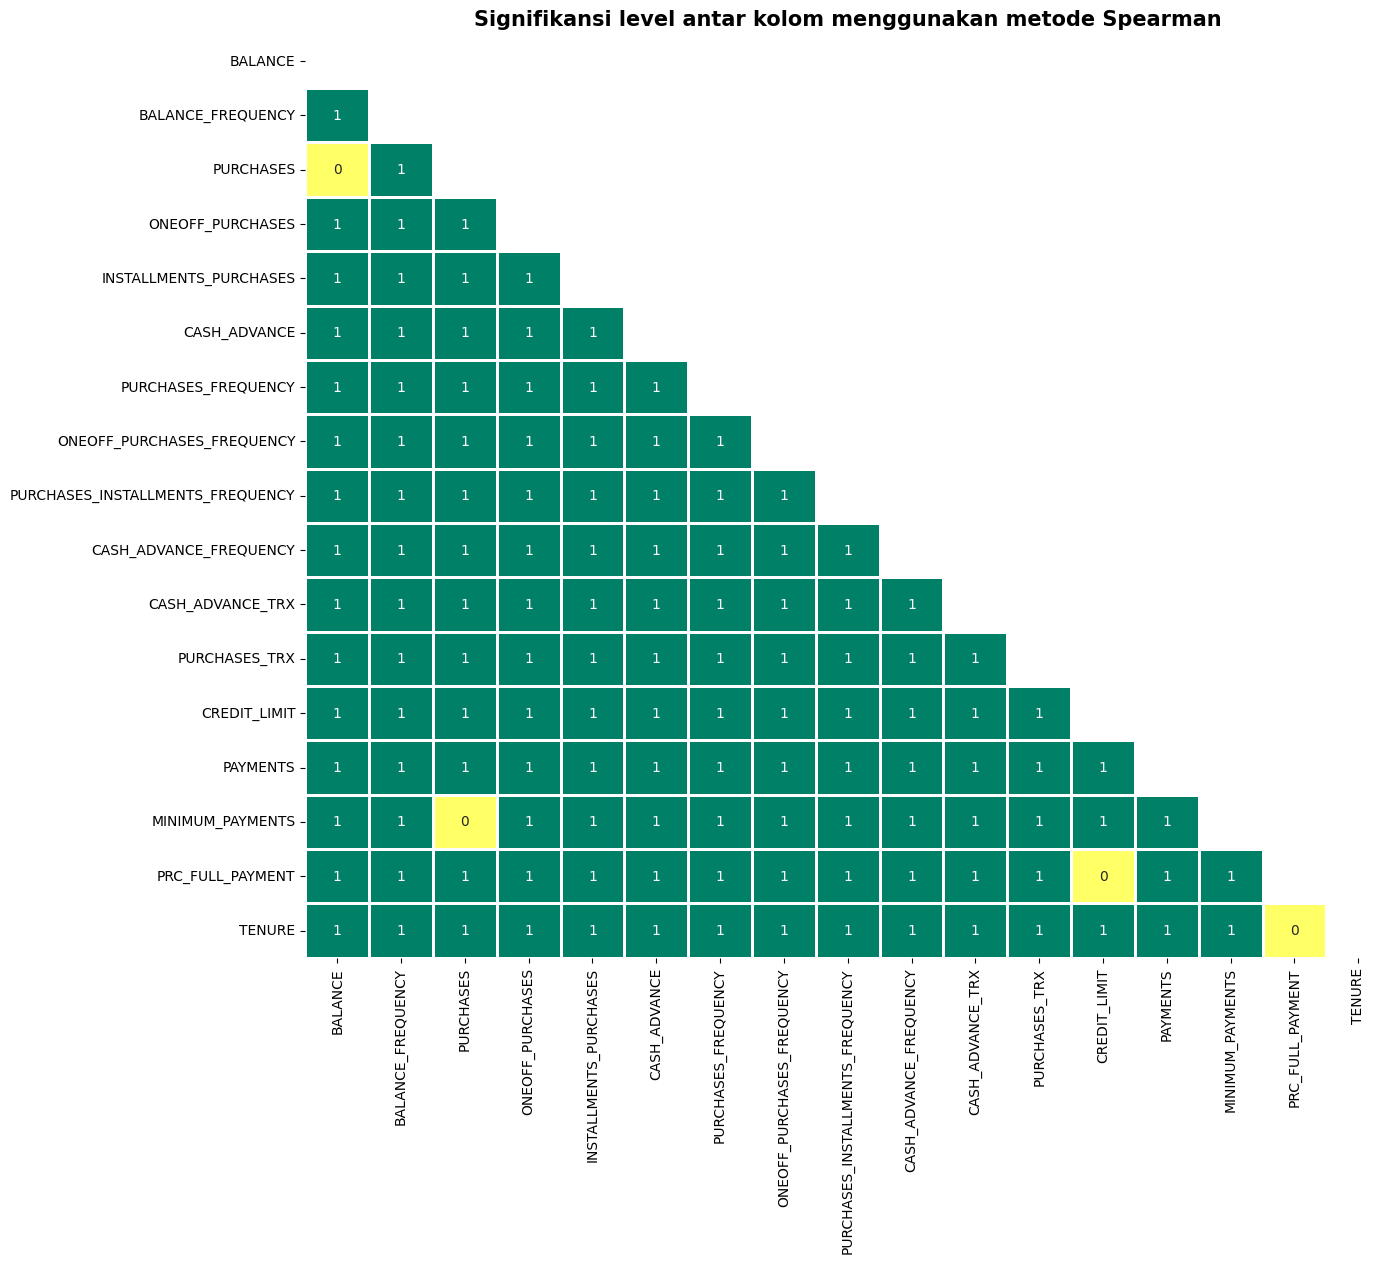

In [ ]:
# cek pvalue data antar kolom

# nilai pvalue masing-masing antar kolom
corr, pvalue = spearmanr(data[data_eda.drop(columns='CUST_ID').dropna().columns].dropna())

# masukkan pvalue ke dalam DataFrame
pvalue_df = pd.DataFrame(pvalue, columns=data_eda.drop(columns='CUST_ID').columns)

# mengubah nilai pvalue menjadi 0 (Tidak memiliki korelasi) atau 1 (memiliki korelasi) pada semua kolom
# jika pvalue lebih kecil dari 0.05, TOLAK H0
# jika pvalue lebih besar dari 0.05, TERIMA H0
pvalue_df = pvalue_df.applymap(lambda x: 0 if x > 0.05 else 1)

# plot nilai pvalue menggunakan grafik heatmap
plt.figure(figsize=(14,12))
plt.title("Signifikansi level antar kolom menggunakan metode Spearman", size=15, fontdict={'weight':'heavy'})
sns.heatmap(data=pvalue_df.set_index(pvalue_df.columns), annot=True, cmap=CUSTOM_SUMMER, linewidths=2, mask=matrix, cbar=False)
plt.show()

**_Insight_**:
- **Berdasarkan uji statistik**, kita punya cukup bukti untuk mengatakan bahwa ****semua kolom memiliki korelasi, KECUALI****:
    - Kolom PURCHASES vs BALANCE dengan nilai korelasi 0.006, PURCHASES vs MINIMUM_PAYMENTS dengan nilai korelasi -0.008, PRC_FULL_PAYMENT vs CREDIT_LIMIT dengan nilai korelasi 0.021, dan PRC_FULL_PAYMENT vs TENURE dengan nilai korelasi 0.020, kita **tidak** punya cukup bukti untuk mengatakan bahwa kolom-kolom tersebut memiliki korelasi

#### 2.3. Melihat Hubungan Antar Kolom

Untuk visualisasi yang bersifat proporsi suatu kategori juga akan dilakukan uji hipotesis proporsi menggunakan _one sample Z-Test_. Uji hipotesis proporsi ini dilakukan untuk melihat apakah proporsi suatu kategori sama dengan 50% atau tidak sama dengan 50%. Jika **proporsi kategori tersebut sama dengan 50%**, maka proporsi kategori tersebut sama dengan proporsi kategori lainnya atau dengan kata lain proporsinya **tidak berbeda secara signifikan**. Sebaliknya, jika **proporsi kategori tersebut tidak sama dengan 50%**, maka proporsi antar kategori tersebut **berbeda secara signifikan**.

Referensi: [Hypothesis Testing for Proportion](https://colab.research.google.com/drive/15MOtCboUxJfR5zXclp5DcasnWJ6GMCdg)

>2.3.1. CREDIT_LIMIT vs PURCHASES, PAYMENTS, dan BALANCE

Melihat bagaimana pengaruh PURCHASES, PAYMENTS, dan BALANCE terhadap CREDIT_LIMIT nasabah

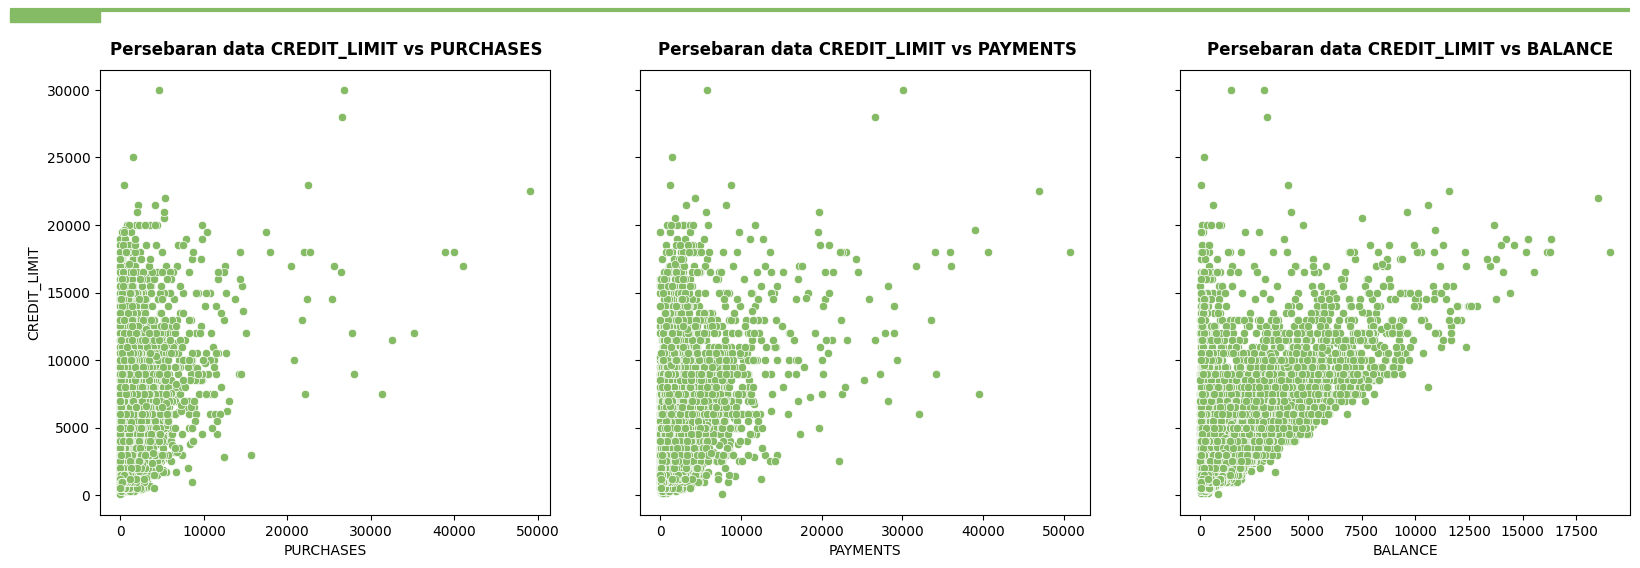

In [ ]:
# melihat hubungan bagaimana CREDIT_LIMIT vs BALANCE dan CREDIT_LIMIT vs PAYMENTS dengan visualisasi grafik

# inisialisasi plot
fig, (ax1,ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18,5), sharey=True)

# adjust subplot
plt.subplots_adjust(left=0.05, top=1)

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.0555, 1.03, "Persebaran data CREDIT_LIMIT vs PURCHASES", fontsize=12, fontweight="bold")
fig.text(0.36, 1.03, "Persebaran data CREDIT_LIMIT vs PAYMENTS", fontsize=12, fontweight="bold")
fig.text(0.665, 1.03, "Persebaran data CREDIT_LIMIT vs BALANCE", fontsize=12, fontweight="bold")

# display grafik
sns.scatterplot(data=data_eda, x='PURCHASES', y='CREDIT_LIMIT', color=COLOR, ax=ax1)
sns.scatterplot(data=data_eda, x='PAYMENTS', y='CREDIT_LIMIT', color=COLOR, ax=ax2)
sns.scatterplot(data=data_eda, x='BALANCE', y='CREDIT_LIMIT', color=COLOR, ax=ax3)

plt.show();

**_Insight_**:
- Ada beberapa pola yang terbentuk, antara lain:
    - Pola semakin besar CREDIT_LIMIT, semakin besar pula BALANCE. Hal ini menunjukkan bahwa terdapat nasabah yang memiliki CREDIT_LIMIT besar, sisa saldo yang masih dapat digunakan juga besar (kedua variabel cenderung semakin besar). Atau dengan kata lain, nasabah tersebut **jarang menggunakan kartu kreditnya** atau nasabah tersebut **sering melakukan pembelian (PURCHASES) dan membayar sesuai tagihannya (PAYMENTS)**
    - Namun, ada juga nasabah yang memiliki CREDIT_LIMIT besar, tapi **tidak ada** sisa saldo yang masih dapat digunakan. Atau dengan kata lain, nasabah tersebut nasabah yang memiliki CREDIT_LIMIT besar, nasabah tersebut cenderung **sering menggunakan kartu kredit**, bahkan sampai tidak ada saldo yang tersisa, tapi **tidak membayar tagihannya (PAYMENTS = 0)**

Referensi:
- [How Credit Card Companies Determine Credit Limit](https://www.investopedia.com/articles/credit-loans-mortgages/081516/how-credit-card-companies-determine-credit-limit-expn.asp#:~:text=What%20Affects%20Your,on%20your%20report.)
- [What Is a Credit Limit? How It's Determined and How to Increase It](https://www.investopedia.com/terms/c/credit_limit.asp#citation-3:~:text=3-,Can%20Lenders%20Change%20Your%20Credit%20Limit%3F,-In%20most%20cases)

>2.3.2. CREDIT_LIMIT vs BALANCE

Melihat selisih antara credit limit yang disediakan oleh **Bank** dengan **Balance** yang tersedia untuk nasabah melakukan transaksi kartu kredit

In [21]:
data_eda['REMAINING_LIMIT'] = data_eda['CREDIT_LIMIT']-data_eda['BALANCE']
data_eda.head()

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000                          0.000000   
2                    1.000000                          0.000000   
3                    0.083333                          0.000000   
4                    0.083333                          0.000000   

   CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
0                0.000000                 0              2        1000.0   
1                0.250000                 4              0        7000.0   
2                0.000000                 0             12        7500.0   
3                0.083333                 1              1        7500.0   
4                0.000000                 0              1        1200.0   

      PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  REMAINING_LIMIT  
0   201.802084        139.509787          0.000000      12       959.099251  
1  4103.032597       1072.340217          0.222222      12      3797.532584  
2   622.066742        627.284787          0.000000      12      5004.851138  
3     0.000000               NaN          0.000000      12      5833.329458  
4   678.334763        244.791237          0.000000      12       382.285665

In [25]:
# membuat fungsi sebagai conditional statments pada kolom baru PURCHASES_TYPE
def remaining_limit_type(df: pd.DataFrame):
    if df['REMAINING_LIMIT'] > 0: return 'KURANG DARI LIMIT'
    elif df['REMAINING_LIMIT'] < 0: return 'LEBIH DARI LIMIT'

# membuat kolom PURCHASES_TYPE
data_eda['REMAINING_LIMIT_TYPE'] = data_eda.apply(remaining_limit_type, axis=1)

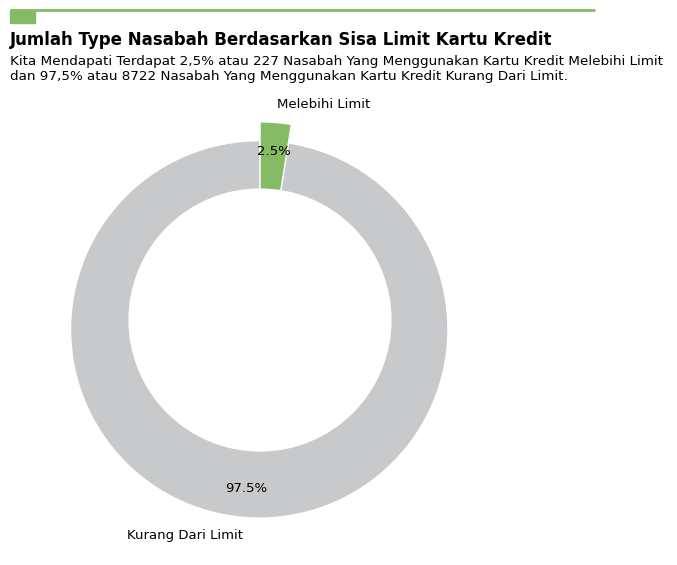

In [43]:
# calculate the customers that have accepted campaign once or more and the customers that never accepted
Value_limit = data_eda['REMAINING_LIMIT_TYPE'].value_counts()
Value_limit1 = data_eda['REMAINING_LIMIT_TYPE'].value_counts().reset_index()

# initialize plot
fig, ax = plt.subplots(figsize=(5, 5))

# adjust the subplot so that the title would fit
plt.subplots_adjust(top=0.9)

# add line and rectangle on top.
fig.add_artist(lines.Line2D([0, 1.17], [1.12, 1.12], lw=2, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# add title
fig.text(
    0, 1.05, "Jumlah Type Nasabah Berdasarkan Sisa Limit Kartu Kredit", 
    fontsize=12,
    fontweight="bold", 
)

# add subtitle
fig.text(
    0, 0.98, 
    f'''Kita Mendapati Terdapat 2,5% atau {Value_limit1['REMAINING_LIMIT_TYPE'][1]} Nasabah Yang Menggunakan Kartu Kredit Melebihi Limit 
dan 97,5% atau {Value_limit1['REMAINING_LIMIT_TYPE'][0]} Nasabah Yang Menggunakan Kartu Kredit Kurang Dari Limit.''',
    fontsize=9.7, 
    color='black'
)

# create pie chart
plt.pie(Value_limit, 
        colors=["#C7C9CB", COLOR],
        labels=['Kurang Dari Limit', 'Melebihi Limit' ], 
        autopct='%1.1f%%', 
        startangle=90, 
        pctdistance=0.85, 
        explode=(0.05, 0.05),
        textprops = {"fontsize": 9.5},
)

# create a circle at the center of the plot
fig = plt.gcf()
fig.gca().add_artist(plt.Circle((0, 0), 0.7, fc='white'))

# # saving figure
# plt.savefig('../reports/figures/station.jpg', bbox_inches='tight')

# show
plt.tight_layout()
plt.show()

**_Insight_**:
- Terdapat 2,5% atau 227 nasabah yang menggunakan kartu kreditnya melebihi limit yang disediakan oleh bank
- Terdapat 97,5% atau 8722 nasabah yang menggunakan kartu kreditnya kurang dari limit yang disediakan oleh bank

>2.3.3. Bagaimana jenis-jenis nasabah jika dilihat dari metode/cara mereka melakukan pembelian ? Apakah secara langsung lunas (ONEOFF) dan/atau secara angsuran (INSTALLMENTS) ?

In [50]:
# membuat fungsi sebagai conditional statments pada kolom baru PURCHASES_TYPE
def purchases_type(df: pd.DataFrame):
    if df['ONEOFF_PURCHASES'] == 0 and df['INSTALLMENTS_PURCHASES'] == 0: return 'NO PURCHASES'
    elif df['ONEOFF_PURCHASES'] > 0 and df['INSTALLMENTS_PURCHASES'] > 0: return 'BOTH'
    elif df['ONEOFF_PURCHASES'] > 0 and df['INSTALLMENTS_PURCHASES'] == 0: return 'ONEOFF'
    elif df['ONEOFF_PURCHASES'] == 0 and df['INSTALLMENTS_PURCHASES'] > 0: return 'INSTALLMENTS'

# membuat kolom PURCHASES_TYPE
data_eda['PURCHASES_TYPE'] = data_eda.apply(purchases_type, axis=1)
# data_eda.sample(5)

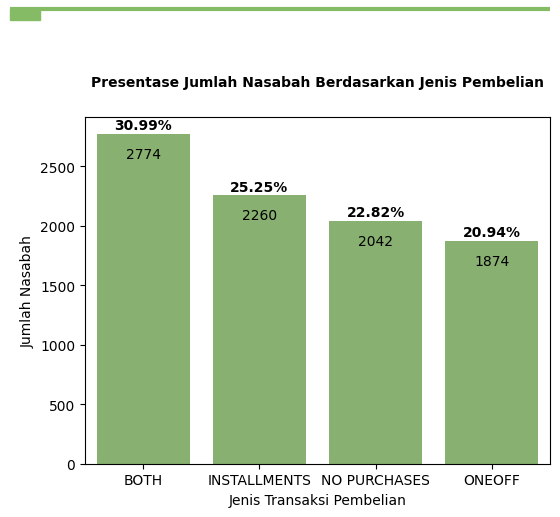

In [51]:
fig, ax = plt.subplots(figsize=(6,4.5))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.135, 0.95, "Presentase Jumlah Nasabah Berdasarkan Jenis Pembelian", fontsize=10, fontweight="bold")

# plot grafik jenis transaksi pembayaran
purchase_type_plot = sns.countplot(
    data=data_eda, 
    x="PURCHASES_TYPE",
    color=COLOR,
    order=data_eda['PURCHASES_TYPE'].value_counts().index
)

# anotasi jumlah nasabah
for bar in purchase_type_plot.patches:
    purchase_type_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -15),
        textcoords='offset points')
    
# anotasi persentase jumlah nasabah
for p in purchase_type_plot.patches:
    percentage = f'{100 * p.get_height() / len(data_eda):.2f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    purchase_type_plot.annotate(percentage, (x, y), ha='center', va='center', size=10, fontweight='bold')

plt.xlabel("Jenis Transaksi Pembelian")
plt.ylabel("Jumlah Nasabah")
plt.show()

**_Insight_**:
- Presentase jenis pembelian nasabah Bank Beta cenderung hampir sama pada semua jenis pembelian, yaitu 20%-30% masing-masing jenis pembelian. Namun, presentase yang paling besar ada pada nasabah yang melakukan pembelian secara lunas (ONEOFF) dan angsuran (INSTALLMENTS), yaitu 30.99%. Kemudian, jika dilihat secara keseluruhan presentase nasabah yang menggunakan kartu kredit atau tidak, **presentase nasabah yang sudah menggunakan kartu kredit** mereka untuk melakukan pembelian sebesar **77.18%**, sedangkan nasabah yang sama sekali **tidak menggunakan kartu kredit** untuk melakukan pembelian sebesar **22.82%**.
- **22.82% nasabah tidak melakukan pembelian sama sekali**. Hal ini mengindikasikan nasabah tersebut memiliki kartu kredit hanya untuk kondisi tertentu atau darurat. Untuk mendorong nasabah tersebut menggunakan kartu kredit sebagai sarana pembelian, hal yang dapat dilakukan Bank Beta adalah dengan melakukan penawaran seperti diskon, cashback, atau bunga angsuran yang rendah pada penggunaan pertama.
- **30.99% nasabah melakukan pembelian secara lunas dan angsuran**. Bank Beta dapat memberikan campaign marketing yang berkaitan dengan kedua jenis pembelian tersebut, misalnya bunga yang rendah ketika nasabah melakukan pembelian secara angsuran atau memberikan diskon ketika nasabah melakukan pembelian secara lunas. 
- **25.25% nasabah hanya melakukan pembelian secara angsuran**. Nasabah yang masuk ke dalam presentase tersebut merupakan nasabah yang lebih menyukai melakukan pembelian secara angsuran. Campaign marketing yang mungkin dilakukan untuk nasabah tersebut adalah dengan memberikan bunga angsuran yang kecil.
- **20.94% nasabah hanya melakukan pembelian secara lunas**. Nasabah yang masuk ke dalam presentase tersebut merupakan nasabah yang lebih menyukai melakukan pembelian secara lunas. Campaign marketing yang mungkin dilakukan untuk nasabah tersebut adalah memberikan diskon atau _cashback_ ketika melakukan pembelian secara lunas.
- ......
- ......

Melakukan **uji hipotesis proporsi menggunakan _one sample Z-Test_** untuk memperkuat analisa di atas dan melihat apakah terdapat perbedaan yang signifikan antara jumlah nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian dengan jumlah nasabah yang tidak menggunakan kartu kredit untuk melakukan pembelian

Hipotesis:
- Ho : Proporsi nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian = 50%
- H1 : Proporsi nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian ≠ 50%

significance level (alpha) = 0.05

In [ ]:
# melakukan uji proporsi one sample z-test

# jumlah nasabah melakukan pembelian
n_pernah_beli = len(data_eda.query("PURCHASES_TYPE == 'BOTH' or PURCHASES_TYPE == 'ONEOFF' or PURCHASES_TYPE == 'INSTALLMENTS'"))
# jumlah total nasabah baik yang melakukan pembelian maupun tidak
n_all_purchases_type = len(data_eda['PURCHASES_TYPE'])

# nilai pvalue
stat, pvalue = proportions_ztest(
    count= n_pernah_beli,     # jumlah nasabah yang menggunakan kartu kredit untuk pembelian
    nobs= n_all_purchases_type,  # jumlah seluruh nasabah
    value= 0.5             # proporsi nasabah yang TIDAK menggunakan kartu kredit untuk pembelian
    )

# cek apakah berbeda secara signifikan atau tidak
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue}. Pvalue > 0.05. MENERIMA Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian sama dengan 50%.
    (Proporsinya TIDAK berbeda signifikan)
    ''')

else:
    print(f'''
    Pvalue = {pvalue}. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian TIDAK sama dengan 50%.
    (Proporsinya berbeda signifikan)
    ''')    


    Pvalue = 0.0. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang sudah menggunakan kartu kredit untuk melakukan pembelian TIDAK sama dengan 50%.
    (Proporsinya berbeda signifikan)
    


**_Insight_**:
- Proporsi nasabah yang menggunakan kartu kredit untuk melakukan pembelian (77.18%) **berbeda secara signifikan** dengan proporsi nasabah yang TIDAK menggunakan kartu kredit untuk melakukan pembelian (22.82%). Hal ini menunjukkan bahwa mayoritas nasabah sudah menggunakan kartu kredit mereka untuk melakukan pembelian

>2.3.4. MINIMUM_PAYMENTS vs PAYMENTS

Melihat apakah nasabah Bank Beta masih memiliki tunggakan (tagihan yang belum terbayarkan) pada kartu kredit mereka atau tidak. Jika nasabah yang pembayarannya (PAYMENTS) lebih dari minimal pembayaran (MINIMUM_PAYMENTS), berarti nasabah tersebut tidak memiliki tunggakan. Sebaliknya, jika nasabah yang pembayarannya kurang dari minimal pembayaran, maka nasabah tersebut masih memiliki tunggakan.

In [44]:
# membuat fungsi sebagai conditional statments pada kolom baru PURCHASES_TYPE
def tagihan(df: pd.DataFrame):
    if df['PAYMENTS'] >= df['MINIMUM_PAYMENTS']: return 'Tidak Ada Tagihan'
    elif df['PAYMENTS'] < df['MINIMUM_PAYMENTS']: return 'Ada Tagihan'
    else: return 'Tidak Diketahui' # nasabah yang MINIMUM_PAYMENTS = NaN

data_eda['TAGIHAN'] = data_eda.apply(tagihan, axis=1)
# data_eda.sample(5)

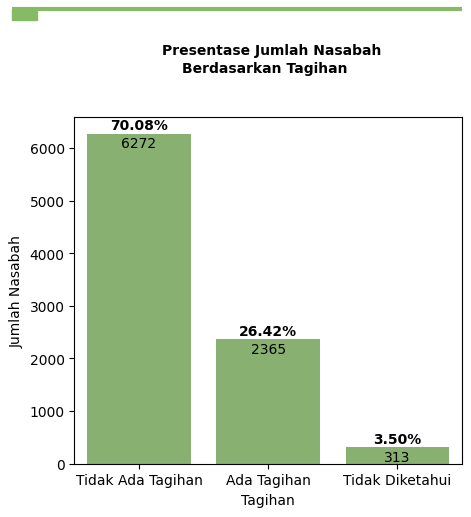

In [45]:
fig, ax = plt.subplots(figsize=(5,4.5))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.3, 1.02, "Presentase Jumlah Nasabah", fontsize=10, fontweight="bold")
fig.text(0.34, 0.98, "Berdasarkan Tagihan", fontsize=10, fontweight="bold")

# plot grafik jenis transaksi pembayaran
angsuran_plot = sns.countplot(
    data=data_eda, 
    x="TAGIHAN",
    color=COLOR,
    order=data_eda['TAGIHAN'].value_counts().index
)

# anotasi jumlah nasabah
for bar in angsuran_plot.patches:
    angsuran_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -7),
        textcoords='offset points')
    
# anotasi persentase jumlah nasabah
for p in angsuran_plot.patches:
    percentage = f'{100 * p.get_height() / len(data_eda):.2f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    angsuran_plot.annotate(percentage, (x, y), ha='center', va='center', size=10, fontweight='bold')

plt.xlabel("Tagihan")
plt.ylabel("Jumlah Nasabah")
plt.show()

**_Insight_**:
- 6272 atau 70.08% nasabah telah membayar tagihan setidaknya sebesar minimum pembayaran, bahkan lebih dari minimum pembayarannya, sehingga mereka tidak memiliki tagihan lagi
- 2365 atau 26.42% nasabah masih memiliki tagihan yang harus dibayarkan
- 313 atau 3.50% nasabah yang tidak diketahui apakah masih memiliki tagihan atau tidak

Melakukan **uji hipotesis proporsi menggunakan _one sample Z-Test_** untuk memperkuat analisa di atas dan melihat apakah terdapat perbedaan yang signifikan antara jumlah nasabah tidak memiliki tagihan dengan jumlah nasabah yang memiliki tagihan

Hipotesis:
- Ho : Proporsi nasabah yang tidak memiliki tagihan = 50%
- H1 : Proporsi nasabah yang tidak memiliki tagihan ≠ 50%

significance level (alpha) = 0.05

In [ ]:
# melakukan uji proporsi one sample z-test

# jumlah nasabah yang tidak pernah melakukan cash advance
n_tidak_tagihan = len(data_eda.query("TAGIHAN == 'Tidak Ada Tagihan'"))
# jumlah total nasabah baik yang tidak ada tagihan maupun masih ada tagihan
n_all_tagihan = len(data_eda['TAGIHAN'])

# nilai pvalue
stat, pvalue = proportions_ztest(
    count= n_tidak_tagihan,     # jumlah nasabah tidak ada tagihan
    nobs= n_all_tagihan,        # jumlah seluruh nasabah
    value= 0.5               # proporsi yang masih tagihan
    )

# cek apakah berbeda secara signifikan atau tidak
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue}. Pvalue > 0.05. MENERIMA Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak memiliki tagihan sama dengan 50%.
    (Proporsinya TIDAK berbeda signifikan)
    ''')

else:
    print(f'''
    Pvalue = {pvalue}. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak memiliki tagihan tidak sama dengan 50%.
    (Proporsinya berbeda signifikan)
    ''')


    Pvalue = 0.0. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak memiliki tagihan tidak sama dengan 50%.
    (Proporsinya berbeda signifikan)
    


**_Insight_**:
- Proporsi nasabah yang tidak memiliki tagihan (70.08%) **berbeda secara signifikan** dengan proporsi nasabah yang masih memiliki tagihan (26.42%). Hal ini menunjukkan bahwa mayoritas nasabah sudah tidak memiliki tagihan

>2.3.5. CASH_ADVANCE_TRX

Jika jumlah transaksi _cash advance_ lebih dari 0, maka nasabah tersebut pernah melakukan _cash advance_. Sebaliknya, jika jumlah transaksi _cash advance_ sama denganb 0, maka nasabah tersebut tidak pernah melakukan _cash advance_. 

In [ ]:
# membuat fungsi conditional statement
def is_cash_advance(df):
    if df['CASH_ADVANCE_TRX'] > 0: return 'Pernah'
    else: return 'Tidak Pernah'

# membuat kolom baru apakah nasabah tersebut pernah melakukan cash advance atau tidak
data_eda['IS_CASH_ADVANCE'] = data_eda.apply(is_cash_advance, axis=1)
# data_eda.sample(5)

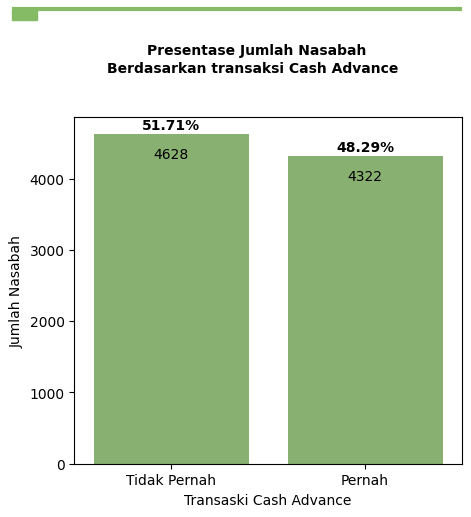

In [ ]:
# melakukan visualisasi grafik IS_CASH_ADVANCE
fig, ax = plt.subplots(figsize=(5,4.5))

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.27, 1.02, "Presentase Jumlah Nasabah", fontsize=10, fontweight="bold")
fig.text(0.19, 0.98, "Berdasarkan transaksi Cash Advance", fontsize=10, fontweight="bold")

# plot grafik jenis transaksi pembayaran
angsuran_plot = sns.countplot(
    data=data_eda, 
    x="IS_CASH_ADVANCE",
    color=COLOR,
    order=data_eda['IS_CASH_ADVANCE'].value_counts().index
)

# anotasi jumlah nasabah
for bar in angsuran_plot.patches:
    angsuran_plot.annotate(
        format(bar.get_height(), '.0f'), (bar.get_x() + bar.get_width() / 2, bar.get_height() + 2), 
        ha='center', 
        va='center',
        size=10, 
        xytext=(0, -15),
        textcoords='offset points')
    
# anotasi persentase jumlah nasabah
for p in angsuran_plot.patches:
    percentage = f'{100 * p.get_height() / len(data_eda):.2f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    angsuran_plot.annotate(percentage, (x, y), ha='center', va='center', size=10, fontweight='bold')

plt.xlabel("Transaski Cash Advance")
plt.ylabel("Jumlah Nasabah")
plt.show()

**_Insight_**:
- 51.73% nasabah tidak pernah melakukan transaksi _cash advance_, sedangkan 48.29% nasabah pernah melakukan transaksi _cash advance_.
- Hal ini menunjukkan terdapat **perbedaan sekitar 3%** antara nasabah yang **pernah melakukan pembayaran sebelum tenure** mereka dengan nasabah yang **tidak pernah melakukan pembayaran sebelum tenure** mereka

Melakukan **uji hipotesis proporsi menggunakan _one sample Z-Test_** untuk memperkuat analisa di atas dan melihat apakah terdapat perbedaan yang signifikan antara jumlah nasabah yang pernah melakukan pembayaran sebelum tenure mereka dengan nasabah yang tidak pernah melakukan pembayaran sebelum tenure mereka

Hipotesis:
- Ho : Proporsi nasabah yang tidak pernah melakukan _cash advance_ = 50%
- H1 : Proporsi nasabah yang tidak pernah melakukan _cash advance_ ≠ 50%

significance level (alpha) = 0.05

In [ ]:
# melakukan uji proporsi one sample z-test

# jumlah nasabah yang tidak pernah melakukan cash advance
n_tidak_pernah = len(data_eda.query("IS_CASH_ADVANCE == 'Tidak Pernah'"))
# jumlah total nasabah baik yang tidak pernah melakukan cash advance maupun yang pernah
n_all_cash_advance = len(data_eda['IS_CASH_ADVANCE'])

# nilai pvalue
stat, pvalue = proportions_ztest(
    count= n_tidak_pernah,     # jumlah nasabah yang tidak pernah melakukan cash advance
    nobs= n_all_cash_advance,  # jumlah seluruh nasabah
    value= 0.4829             # proporsi yang pernah melakukan cash advance
    )

# cek apakah berbeda secara signifikan atau tidak
if pvalue > 0.05:
    print(f'''
    Pvalue = {pvalue}. Pvalue > 0.05. MENERIMA Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak pernah melakukan cash advance sama dengan 50%.
    (Proporsinya TIDAK berbeda signifikan)
    ''')

else:
    print(f'''
    Pvalue = {pvalue}. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak pernah melakukan cash advance tidak sama dengan 50%.
    (Proporsinya berbeda signifikan)
    ''')


    Pvalue = 9.5582802222515e-11. Pvalue <= 0.05. MENOLAK Ho.
    Kita punya cukup bukti untuk mengatakan bahwa proporsi nasabah yang tidak pernah melakukan cash advance tidak sama dengan 50%.
    (Proporsinya berbeda signifikan)
    


**_Insight_**:
- Proporsi nasabah yang tidak pernah melakukan _cash advance_ (51.73%) **berbeda secara signifikan** dengan proporsi nasabah yang pernah melakukan _cash advance_ (48.29%). Hal ini menunjukkan bahwa mayoritas nasabah pernah melakukan _cash advance_ paling minimal 1



2.3.5. .......

.....

.....

dst

In [47]:
# number of spent category
Pivot_tagihan_limit = data_eda[['TAGIHAN','REMAINING_LIMIT_TYPE']].pivot_table(
    index= 'TAGIHAN',
    columns= 'REMAINING_LIMIT_TYPE',
    values= 'REMAINING_LIMIT_TYPE',
    aggfunc= len
)

Pivot_tagihan_limit

REMAINING_LIMIT_TYPE  KURANG DARI LIMIT  LEBIH DARI LIMIT
TAGIHAN                                                  
Ada Tagihan                        2170               194
Tidak Ada Tagihan                  6242                30
Tidak Diketahui                     310                 3

In [48]:
# number of spent category
Pivot_tenure_limit = data_eda[['TENURE','REMAINING_LIMIT_TYPE']].pivot_table(
    index= 'TENURE',
    columns= 'REMAINING_LIMIT_TYPE',
    values= 'REMAINING_LIMIT_TYPE',
    aggfunc= len
)

Pivot_tenure_limit

REMAINING_LIMIT_TYPE  KURANG DARI LIMIT  LEBIH DARI LIMIT
TENURE                                                   
6                                 202.0               1.0
7                                 190.0               NaN
8                                 193.0               3.0
9                                 175.0               NaN
10                                235.0               1.0
11                                358.0               7.0
12                               7369.0             215.0

In [52]:
# number of spent category
Pivot_purchase_limit = data_eda[['PURCHASES_TYPE','REMAINING_LIMIT_TYPE']].pivot_table(
    index= 'PURCHASES_TYPE',
    columns= 'REMAINING_LIMIT_TYPE',
    values= 'REMAINING_LIMIT_TYPE',
    aggfunc= len
)

Pivot_purchase_limit

REMAINING_LIMIT_TYPE  KURANG DARI LIMIT  LEBIH DARI LIMIT
PURCHASES_TYPE                                           
BOTH                               2716                58
INSTALLMENTS                       2136               124
NO PURCHASES                       2019                22
ONEOFF                             1851                23

### 3. Identifikasi _missing values_, data _outlier_, nilai ambigu, dan data duplikat 

#### 3.1. Identifikasi _Missing Values_

In [ ]:
# check apakah terdapat kolom yang memiliki missing values
check_missing = data.isna().sum()
count = 0
# cek apakah terdapat nilai 0 (tidak ada missing values)
if any(check_missing.values) == False:
    print("Tidak terdapat \x1B[3mmissing values\x1B[0m")
# print kolom yang memiliki missing values
else:
    print("Terdapat \x1B[3mmissing values\x1B[0m:")
    for cols, jmlh_baris in dict(check_missing).items():
        # collect kolom yang terdapat missing values
        if jmlh_baris > 0:
            count += 1
            print(f"{count}. Sebanyak \x1b[31m{jmlh_baris} baris\x1b[0m atau \x1b[31m{round(jmlh_baris/len(data)*100,3)}%\x1b[0m pada kolom {cols}")

Terdapat missing values:
1. Sebanyak 1 baris atau 0.011% pada kolom CREDIT_LIMIT
2. Sebanyak 313 baris atau 3.497% pada kolom MINIMUM_PAYMENTS


**_Insight_**:
- Terdapat 2 kolom yang memiliki **missing values**, yaitu pada kolom **CREDIT_LIMIT** dan **MINIMUM_PAYMENTS**, masing-masing sebanyak **1 baris atau 0.011%** dan **313 baris atau 3.497%**.

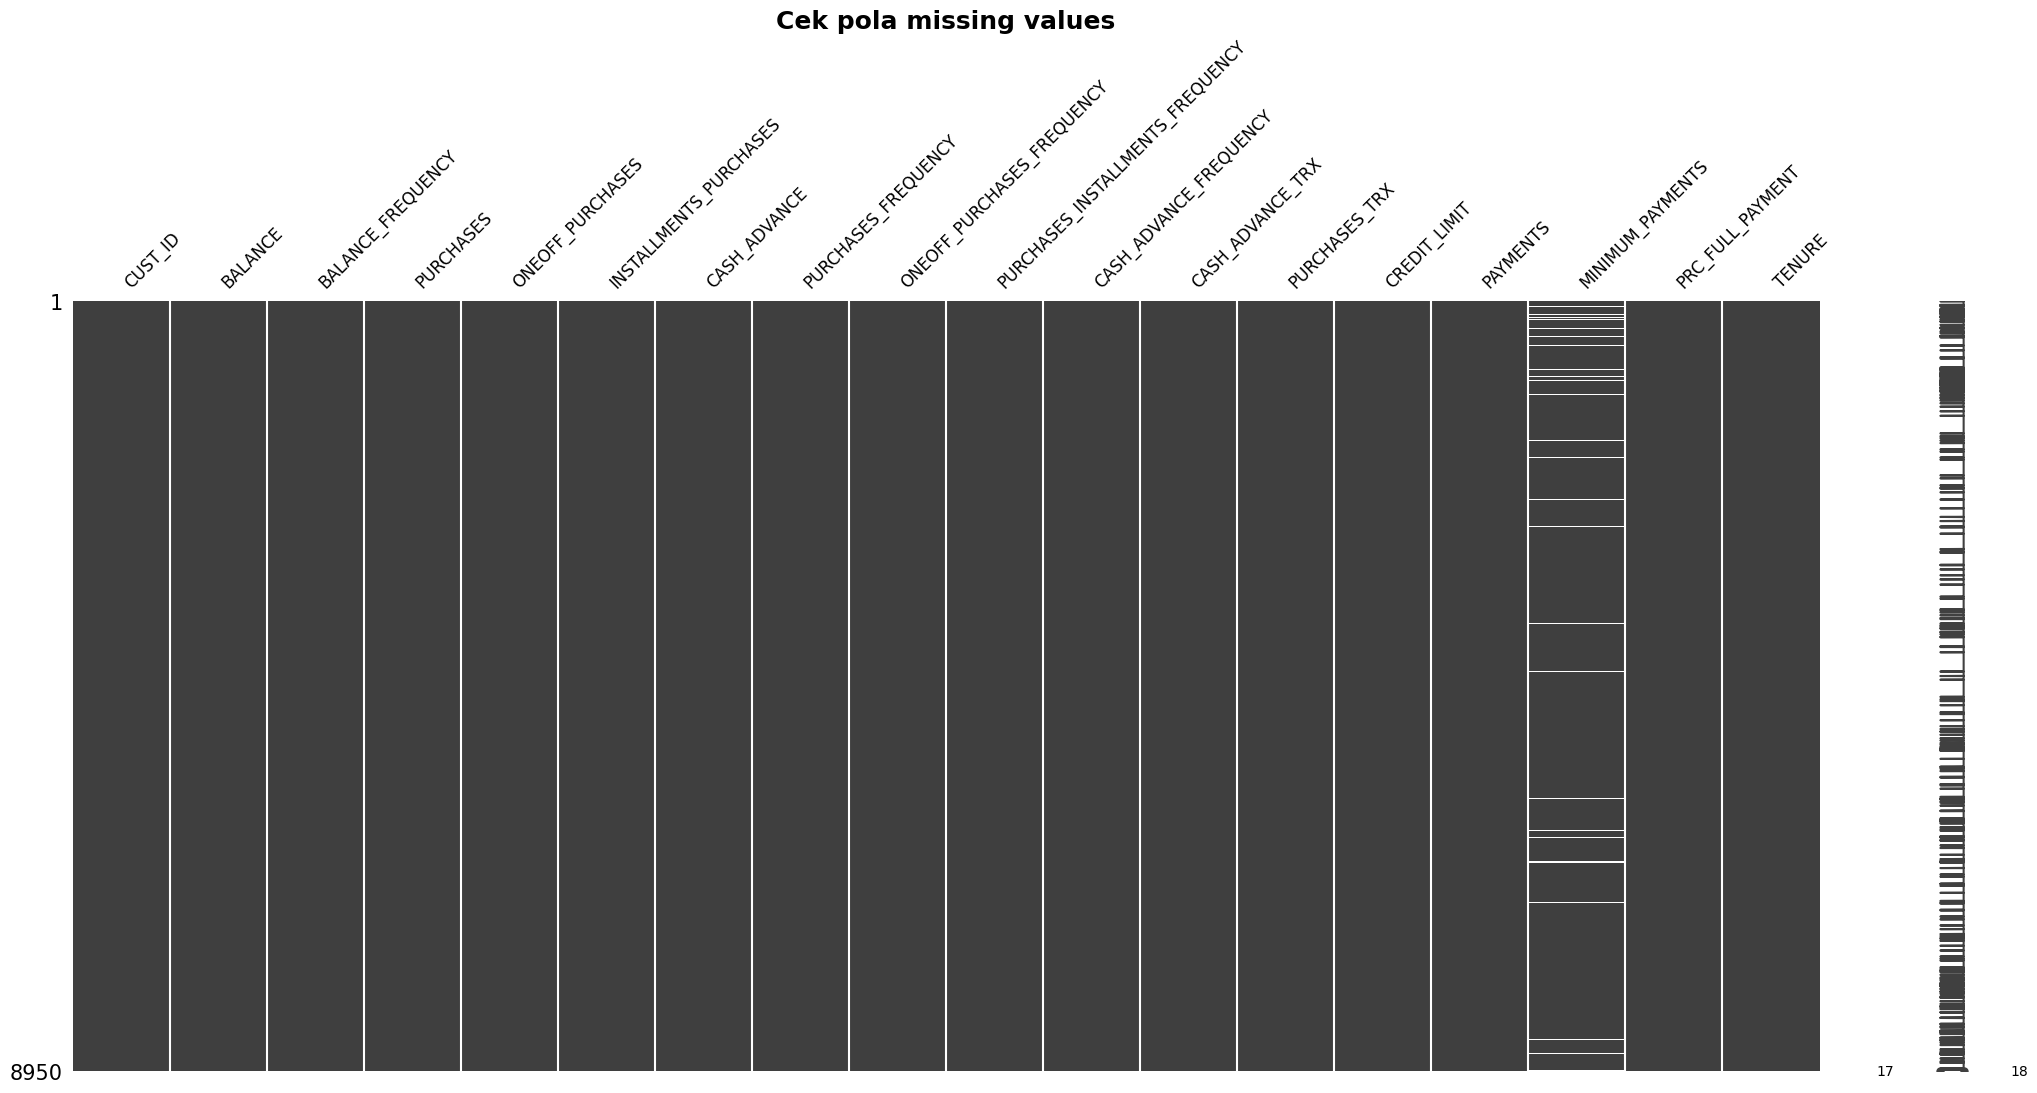

In [ ]:
# cek pola missing values dengan menggunakan library missingno matrix
msno.matrix(data, fontsize=12)
plt.title("Cek pola missing values", fontsize=18, weight="bold")
plt.show()

**_Insight_**:
- _Missing values_ tidak menunjukkan pola tertentu terhadap data variabel itu sendiri dan/atau _missing values_ pada variabel variabel lainnya (Missing at Random)

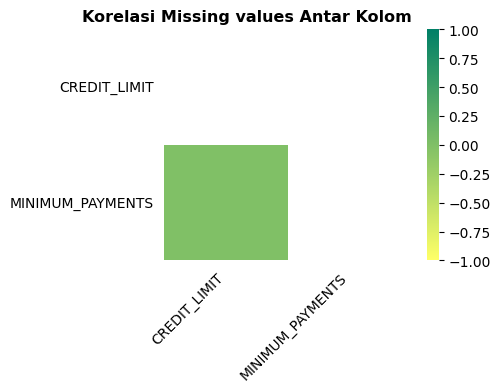

In [ ]:
# cek bagaimana korelasi missing values antar kedua kolom tersebut
msno.heatmap(data, cmap=CUSTOM_SUMMER, figsize=(4,3))
# judul grafik
plt.title("Korelasi Missing values Antar Kolom", size=11.5, loc='right', fontweight='bold')
# ukuran xticks dan yticks
plt.xticks(size=10)
plt.yticks(size=10)
# display grafik
plt.show();

**_Insight_**:
- **Tidak ada korelasi** missing values antara kolom CREDIT_LIMIT dan MINIMUM_PAYMENTS

**Note:**
Namun, berdasarkan korelasi data antar kolom di atas (EDA 2.2. Cek Korelasi Data Antar Kolom Menggunakan Metode Spearman) dan diperkuat dengan _domain knowledge_, CREDIT_LIMIT dan MINIMUM_PAYMENTS suatu nasabah dapat dipengaruhi oleh bagaimana riwayat transaksi nasabah tersebut. Oleh karena itu, imputasi _missing values_ pada kolom tersebut akan menggunakan metode KNNImputer. Kemudian, setelah melakukan imputasi, akan dilakukan uji statistik menggunakan metode _two samples Kolmogorov-Smirnov Test_, metode ini melihat apakah kedua sampel berasal dari distribusi yang sama atau tidak.

Referensi:
- [What To Know About Credit Card Minimum Payments](https://www.forbes.com/advisor/credit-cards/credit-card-minimum-payments/#:~:text=In%20this%20case%2C%20the%20minimum,A%20flat%20rate.)
- [What Happens To Your Balance And Credit Score When You Pay Only The Minimum On Your Credit Card?](https://www.forbes.com/advisor/credit-cards/what-happens-to-your-balance-and-credit-score-when-you-pay-only-the-minimum-on-your-credit-card/)
- [What Is a Credit Limit? How It's Determined and How to Increase It](https://www.investopedia.com/terms/c/credit_limit.asp#:~:text=Products%20like%20credit%20cards%20and,typically%20receive%20higher%20credit%20limits.)
- [How Credit Card Issuers Set Your Credit Limit](https://www.forbes.com/advisor/credit-cards/how-credit-card-issuers-set-your-credit-limit/)
- [How to Perform a Kolmogorov-Smirnov Test in Python](https://www.statology.org/kolmogorov-smirnov-test-python/#:~:text=p%2Dvalue%20is%20less%20than%20.05%2C%20we%20reject%20the%20null%20hypothesis.%20We%20have%20sufficient%20evidence%20to%20say%20that%20the%20two%20sample%20datasets%20do%20not%20come%20from%20the%20same%20distribution.)
- [scipy.stats.ks_2samp documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#:~:text=two%2Dsided%3A%20The%20null%20hypothesis%20is%20that%20the%20two%20distributions%20are%20identical%2C%20F(x)%3DG(x)%20for%20all%20x%3B%20the%20alternative%20is%20that%20they%20are%20not%20identical.)

#### 3.2. Identifikasi Data Outlier secara _Univariate Analysis_ menggunakan Box Plot dan IQR

Deteksi data _outlier_ secara _univariate_: Melihat apakah suatu data memiliki **nilai yang ekstrem** berdasarkan **hanya** variabel data tersebut.

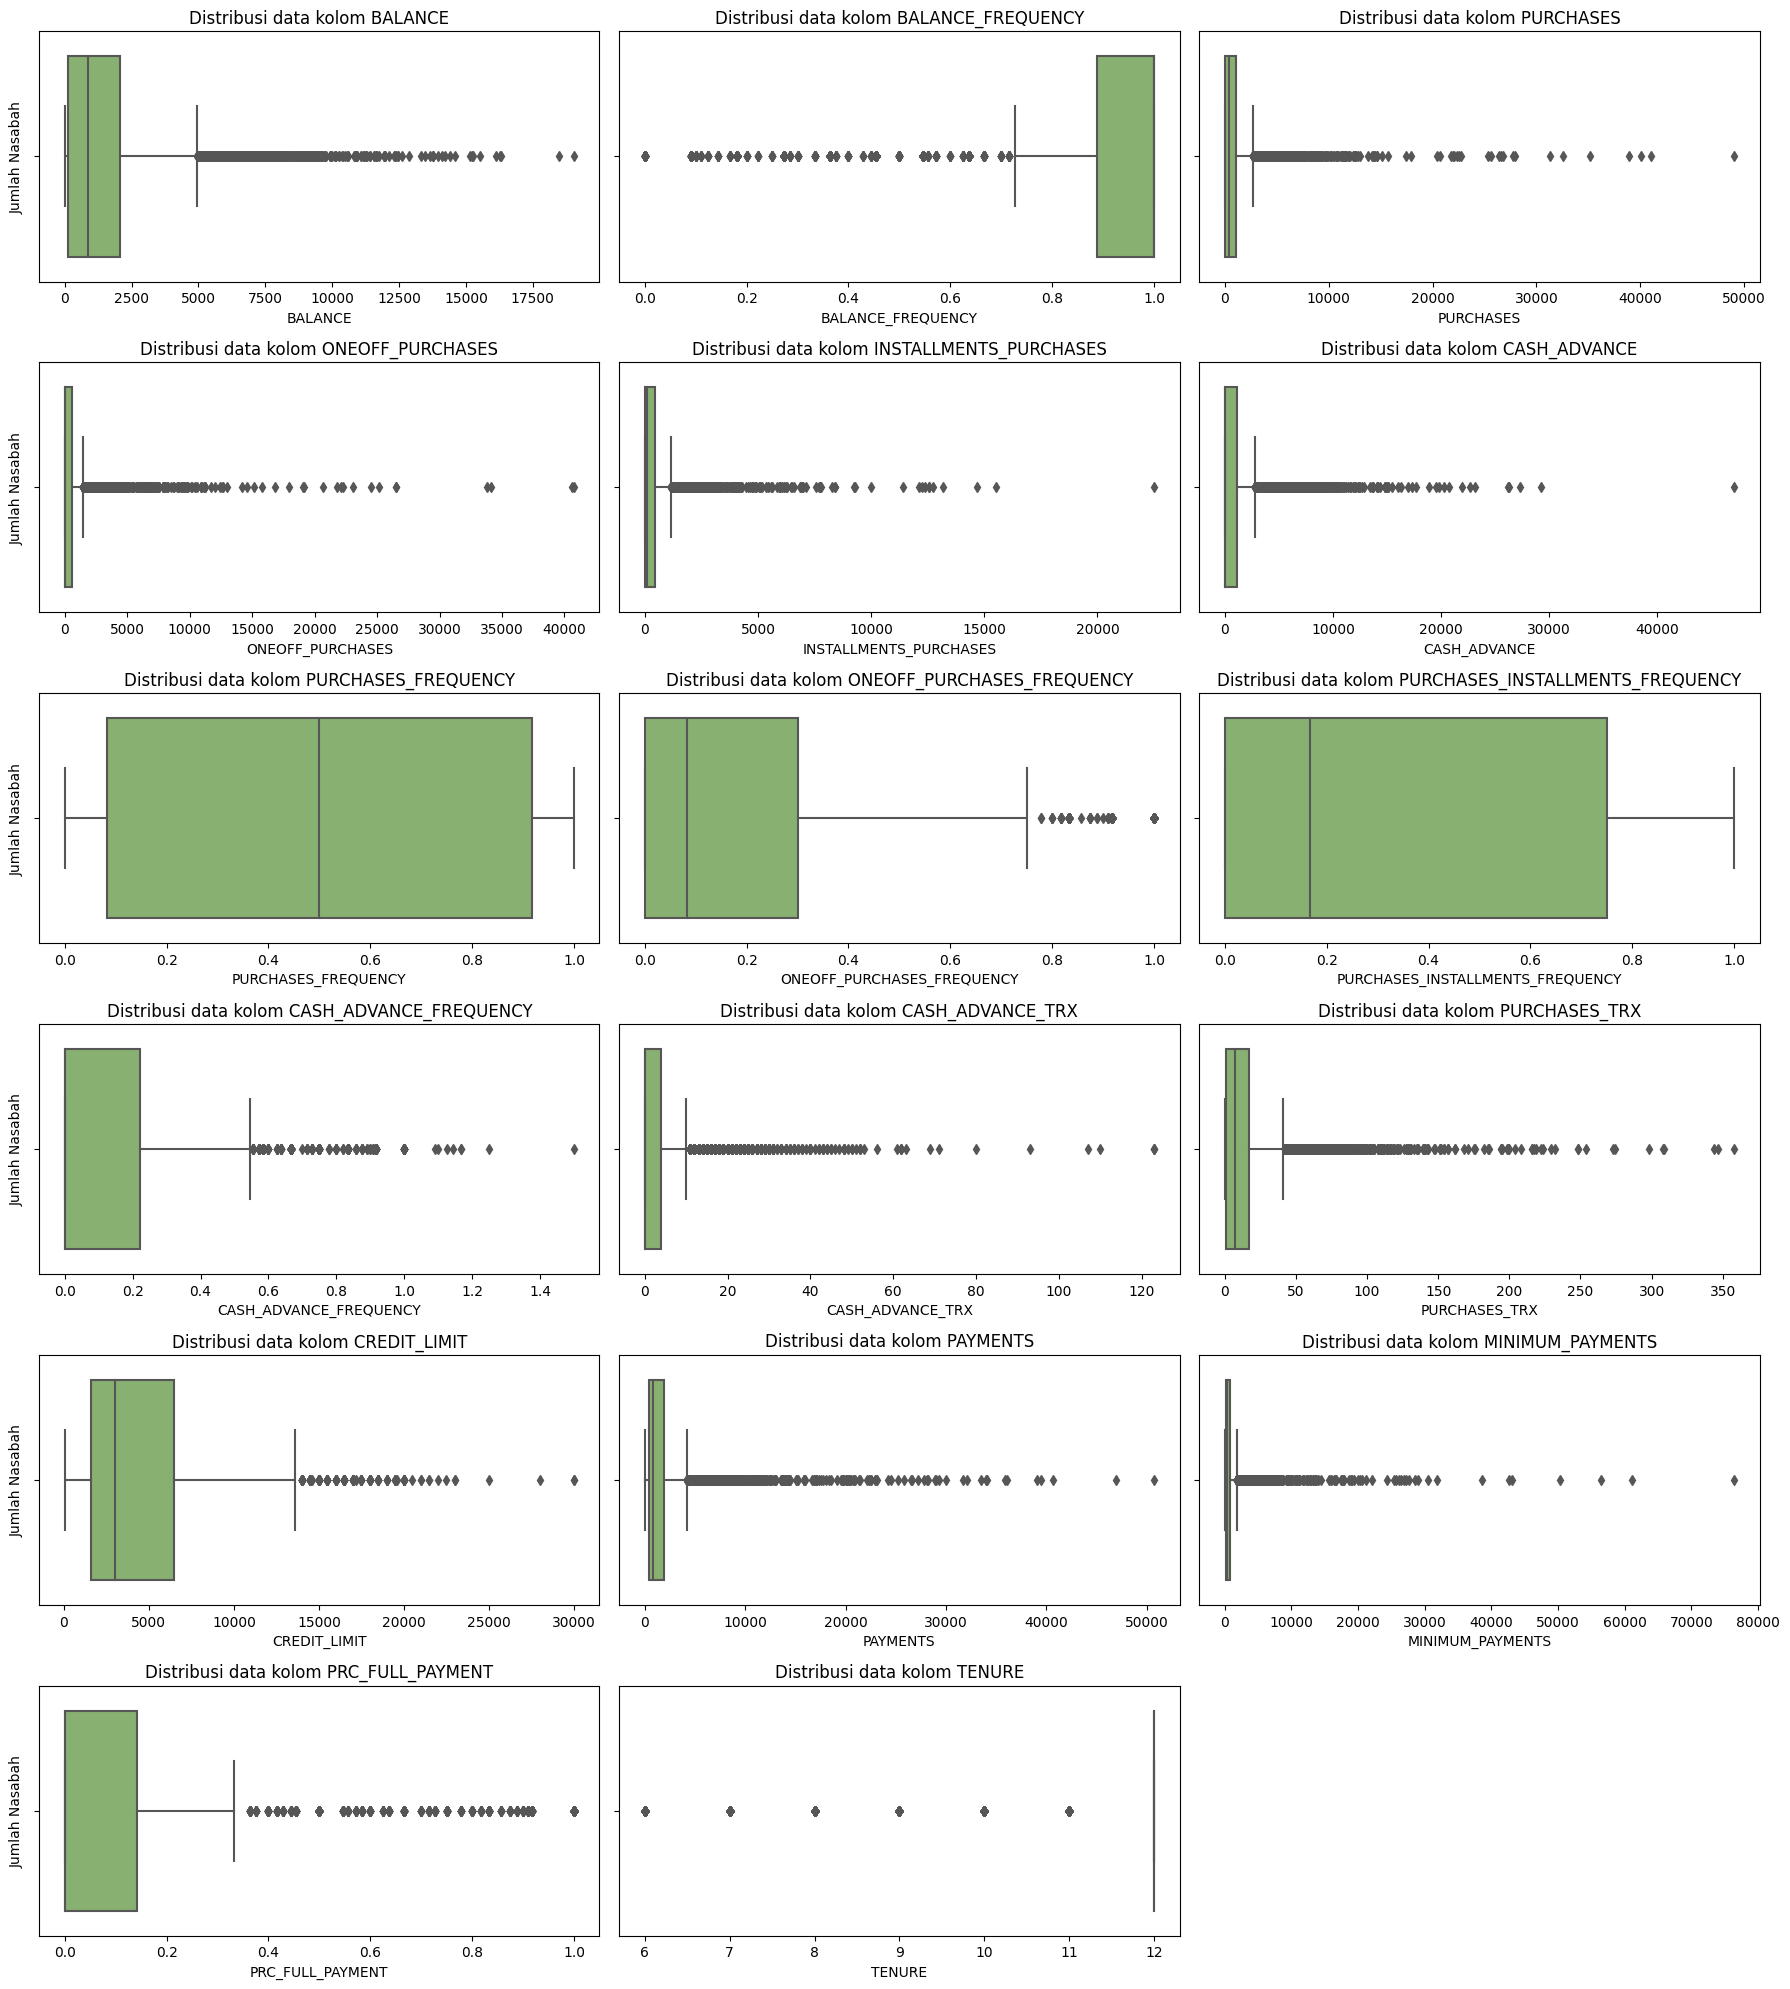

In [ ]:
# plot distributi data dari semua kolom menggunakan histogram plot
count = 0
fig = plt.figure(figsize=(18, 20))
for feature in data.drop(columns='CUST_ID').columns:
    count +=1
    ax = plt.subplot(6,3,count)
    sns.boxplot(data=data.drop(columns='CUST_ID'), x=feature, color=COLOR)
    plt.title(f"Distribusi data kolom {feature}")
    if count in [1,4,7,10,13,16]:
        plt.ylabel("Jumlah Nasabah")
    fig.tight_layout()
plt.show()

**_Insight_**:
- Berdasarkan visualiasi grafik di atas, hampir semua kolom memiliki data outlier, kecuali pada kolom PURCHASES_FREQUENCY dan PURCHASES_INSTALLMENTS_FREQUENCY.
- Data outlier pada kolom-kolom tersebut masih dinilai masuk akal/wajar (weak outlier/noise), namun ada beberapa data yang bersifat _strong outlier_ seperti pada kolom CASH_ADVANCE dan INSTALLMENTS_PURCHASES. Kemungkinan hal ini terjadi ketika nasabah tersebut menggunakan kartu kredit untuk keadaan yang sangat darurat.
- ......
- ......

Referensi: [C. C. Aggarwal, "An Introduction to Outlier Analysis" in Outlier Analysis, 2nd ed. New York, USA: Springer Nature, 2017, pp.3.](https://charuaggarwal.net/outlierbook.pdf)

In [53]:
# cek presentase data outlier pada kolom yang memiliki data outlier
cols = data.drop(columns='CUST_ID').columns
result = []

# cek data outlier untuk semua kolom
for index, column in enumerate(cols):
    # variabel-variabel untuk cek data outlier
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR*1.5)
    upper_bound = Q3 + (IQR*1.5)
    # kondisi untuk data yang outlier
    condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    # jumlah data outlier (jika ada)
    n_data_outlier = data.loc[condition, column].count()
    # presentase jumlah data outlier (jika ada)
    prc_data_outlier = n_data_outlier/data[column].count()*100
    # conditional statements untuk cek apakah data tersebut mengandung outlier atau tidak
    # jika tidak terdapat outlier
    if n_data_outlier == 0:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':'TIDAK terdapat data outlier'})
    # jika terdapat outlier (> 0% s/d 10%)
    elif prc_data_outlier > 0 and prc_data_outlier < 10:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':"terdapat data outlier (0% - 10%)"})
    else:
        result.append({'kolom': column, 'n_baris':n_data_outlier, 'prc_baris':prc_data_outlier, 'keterangan':"terdapat data outlier (> 10%)"})

# DataFrame data outlier
outlier_result = pd.DataFrame(result)
# sort berdasarkan prc_baris Z - A
outlier_result.sort_values('prc_baris', ascending=False)\
    .style.highlight_between(subset='prc_baris', axis=1, left=10, props=PROPS)

In [61]:
data.loc[condition]

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
16    C10017  2072.074354           0.875000       0.00              0.00   
24    C10025  5368.571219           1.000000       0.00              0.00   
36    C10037  7427.076941           1.000000       0.00              0.00   
46    C10048   474.447149           0.500000     109.74              0.00   
50    C10052  4931.331857           1.000000     901.42            646.07   
...      ...          ...                ...        ...               ...   
8945  C19186    28.493517           1.000000     291.12              0.00   
8946  C19187    19.183215           1.000000     300.00              0.00   
8947  C19188    23.398673           0.833333     144.40              0.00   
8948  C19189    13.457564           0.833333       0.00              0.00   
8949  C19190   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
16                      0.00   2784.274703             0.000000   
24                      0.00    798.949863             0.000000   
36                      0.00   8873.375046             0.000000   
46                    109.74   1013.659552             0.375000   
50                    255.35   8530.648614             0.625000   
...                      ...           ...                  ...   
8945                  291.12      0.000000             1.000000   
8946                  300.00      0.000000             1.000000   
8947                  144.40      0.000000             0.833333   
8948                    0.00     36.558778             0.000000   
8949                    0.00    127.040008             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
16                      0.000000                          0.000000   
24                      0.000000                          0.000000   
36                      0.000000                          0.000000   
46                      0.000000                          0.250000   
50                      0.375000                          0.250000   
...                          ...                               ...   
8945                    0.000000                          0.833333   
8946                    0.000000                          0.833333   
8947                    0.000000                          0.666667   
8948                    0.000000                          0.000000   
8949                    0.666667                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
16                  0.250000                 3              0        3000.0   
24                  0.363636                 4              0        6000.0   
36                  0.727273                11              0        9000.0   
46                  0.125000                 1              3        1700.0   
50                  0.875000                37              9       12000.0   
...                      ...               ...            ...           ...   
8945                0.000000                 0              6        1000.0   
8946                0.000000                 0              6        1000.0   
8947                0.000000                 0              5        1000.0   
8948                0.166667                 2              0         500.0   
8949                0.333333                 2             23        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
16     391.974562        376.579631              0.00       8  
24    1422.726707       1657.002877              0.00      11  
36    1636.361601       1986.843608              0.00      11  
46     176.013005        147.199792              0.00       8  
50    8113.297346       1012.415961              0.00       8  
...           ...               ...               ...     ...  
8945   325.594462         48.886365  

In [77]:
data.loc[condition].value_counts()

CUST_ID  BALANCE      BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  PAYMENTS     MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE
C10017   2072.074354  0.875000           0.00       0.00              0.00                    2784.274703   0.000000             0.000000                    0.000000                          0.250000                3                 0              3000.0        391.974562   376.579631        0.0               8         1
C17796   294.720216   1.000000           1880.00    0.00              1880.00                 0.000000      1.000000             0.000000                    0.833333                          0.000000                0                 6              1000.0        1479.018473  87.232429         1.0               6         1
C17637   743.528280   1.000000      

In [98]:
data.loc[condition]

CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
16    C10017  2072.074354           0.875000       0.00              0.00   
24    C10025  5368.571219           1.000000       0.00              0.00   
36    C10037  7427.076941           1.000000       0.00              0.00   
46    C10048   474.447149           0.500000     109.74              0.00   
50    C10052  4931.331857           1.000000     901.42            646.07   
...      ...          ...                ...        ...               ...   
8945  C19186    28.493517           1.000000     291.12              0.00   
8946  C19187    19.183215           1.000000     300.00              0.00   
8947  C19188    23.398673           0.833333     144.40              0.00   
8948  C19189    13.457564           0.833333       0.00              0.00   
8949  C19190   372.708075           0.666667    1093.25           1093.25   

      INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
16                      0.00   2784.274703             0.000000   
24                      0.00    798.949863             0.000000   
36                      0.00   8873.375046             0.000000   
46                    109.74   1013.659552             0.375000   
50                    255.35   8530.648614             0.625000   
...                      ...           ...                  ...   
8945                  291.12      0.000000             1.000000   
8946                  300.00      0.000000             1.000000   
8947                  144.40      0.000000             0.833333   
8948                    0.00     36.558778             0.000000   
8949                    0.00    127.040008             0.666667   

      ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
16                      0.000000                          0.000000   
24                      0.000000                          0.000000   
36                      0.000000                          0.000000   
46                      0.000000                          0.250000   
50                      0.375000                          0.250000   
...                          ...                               ...   
8945                    0.000000                          0.833333   
8946                    0.000000                          0.833333   
8947                    0.000000                          0.666667   
8948                    0.000000                          0.000000   
8949                    0.666667                          0.000000   

      CASH_ADVANCE_FREQUENCY  CASH_ADVANCE_TRX  PURCHASES_TRX  CREDIT_LIMIT  \
16                  0.250000                 3              0        3000.0   
24                  0.363636                 4              0        6000.0   
36                  0.727273                11              0        9000.0   
46                  0.125000                 1              3        1700.0   
50                  0.875000                37              9       12000.0   
...                      ...               ...            ...           ...   
8945                0.000000                 0              6        1000.0   
8946                0.000000                 0              6        1000.0   
8947                0.000000                 0              5        1000.0   
8948                0.166667                 2              0         500.0   
8949                0.333333                 2             23        1200.0   

         PAYMENTS  MINIMUM_PAYMENTS  PRC_FULL_PAYMENT  TENURE  
16     391.974562        376.579631              0.00       8  
24    1422.726707       1657.002877              0.00      11  
36    1636.361601       1986.843608              0.00      11  
46     176.013005        147.199792              0.00       8  
50    8113.297346       1012.415961              0.00       8  
...           ...               ...               ...     ...  
8945   325.594462         48.886365  

In [95]:
test_data = data.replace(data.loc[condition].values(), np.NaN)

TypeError: 'numpy.ndarray' object is not callable

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

**_Insight_**:
- Kolom-kolom yang memiliki data outlier, rentang presentase datanya mulai dari **2%-16.68%** dari total data (8950 data)
- Kolom yang memiliki data outlier sebanyak **lebih dari 10%**: BALANCE_FREQUENCY, PRC_FULL_PAYMENT, TENURE, CASH_ADVANCE, dan ONEOFF_PURCHASES. Selain itu, lebih kecil dari 10%
- Terdapat pola pada data outlier PURCHASES dan PAYMENTS, yaitu jumlah datanya sama besar, yaitu 808 baris atau 9.03% dari total nasabah

In [ ]:
# cek lebih lanjut apakah data nasabah yang termasuk outlier tersebut merupakan nasabah yang sama atau mungkin ada yang sama, jika dilihat berdasarkan kolom PURCHASES dan PAYMENTS
col_list = ['PURCHASES', 'PAYMENTS']
# data outlier nasabah PURCHASES
data_out_PURCHASES = ''
# data outlier nasabah PAYMENTS
data_out_PAYMENTS = ''
for column in col_list:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (IQR*1.5)
    upper_bound = Q3 + (IQR*1.5)
    condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    data_nasabah = data.loc[condition, 'CUST_ID'].values
    if column == 'PURCHASES':
        # collect CUST_ID data nasabah yang termasuk outlier pada kolom PURCHASES
        data_out_PURCHASES = data_nasabah
    else:
        # collect CUST_ID data nasabah yang termasuk outlier pada kolom PAYMENTS
        data_out_PAYMENTS = data_nasabah

# cek CUST_ID nasabah yang termasuk outlier pada kolom PURCHASES ada di PAYMENTS juga
nasabah_sama = 0
for cust_id in data_out_PURCHASES:
    if cust_id in data_out_PAYMENTS:
        nasabah_sama +=1
    else:
        continue
print(f"Jumlah nasabah yang sama sebanyak {nasabah_sama} nasabah ({round(((nasabah_sama/len(data))*100),3)}% dari total nasabah)")

Jumlah nasabah yang sama sebanyak 356 nasabah (3.978% dari total nasabah)


**_Insight_**:
- Ternyata terdapat **3.978% dari total nasabah atau 356 nasabah yang sama** pada data outlier berdasarkan kolom PURCHASES dan PAYMENTS. Nasabah ini merupakan nasabah yang melakukan pembelian (PURCHASES) dan total tagihan yang dibayarkan (PAYMENTS) lebih besar daripada nasabah lain pada umumnya

#### 3.3. Identifikasi nilai ambigu (Ambigous Values)

Mengidentifikasi apakah nilai-nilai atau data pada setiap kolom wajar atau tidak. Pada kolom-kolom yang bersifat frekuensi, seperti PURCHASES FREQUENCY, BALANCE_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, dsb, jika dilihat dari tipe data dan nilai-nilainya, menunjukkan bahwa bahwa kolom tersebut bersifat _relative frequency_, yaitu nilai proporsi/persentase/fraksi dari suatu jumlah data tertentu terhadap jumlah total data. **Nilainya harus berada diantara 0 dan 1.**

Referensi:
- [Stephanie Glen. "Relative Frequency Distribution: Definition and Examples" From StatisticsHowTo.com: Elementary Statistics for the rest of us!](https://www.statisticshowto.com/probability-and-statistics/statistics-definitions/relative-frequency-distribution/)
- [Kaeli Gardner. "What is Relative Frequency?" From study.com](https://study.com/learn/lesson/what-is-relative-frequency.html#:~:text=Well%2C%20the%20relative,proportion%20or%20percentage.)
- [Difference Between Frequency and Relative Frequency](https://www.geeksforgeeks.org/difference-between-frequency-and-relative-frequency/#:~:text=Relative%20frequency%20is%20the%20proportion%20or%20percentage%20of%20times%20a%20specific%20value%20or%20category%20appears%20in%20a%20dataset.)

In [ ]:
# skim data berdasarkan kolom frekuensi
freq_column = ['BALANCE_FREQUENCY', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY']
skim_freq_df = pd.DataFrame(
                {
                'kolom': data[freq_column].columns.values,
                'min': data[freq_column].min().values,
                'max': data[freq_column].max().values,
                'sample_unique': [data[col].unique()[:10] for col in data[freq_column].columns]
                }
            )
# highlight frekuensi yang lebih dari 1
skim_freq_df.style.highlight_between(subset='max', axis=1, left=1.0000001, props=PROPS)

**_Insight_**:
- Berdasarkan referensi di atas, terdapat **nilai yang ambigu** pada kolom **CASH_ADVANCE_FREQUENCY karena memiliki nilai maksimal 1.5**. Padahal berdasarkan teori, seharusnya nilai maksimal dari suatu data yang bersifat _relative frequency_ adalah 1

#### 3.4. Identifikasi Data Duplikat

Karena nantinya kolom CUST_ID tidak digunakan untuk analisa selanjutnya, maka pengecekan duplikat data juga tanpa kolom CUST_ID. Hal ini juga berguna untuk memastikan apakah terdapat data nasabah yang tercatat lebih dari 1 kali, walaupun CUST_ID-nya berbeda, jika ada, kemungkinan telah terjadi _human error_ atau _bug_ pada sistem ketika proses memasukan data nasabah tersebut.

In [ ]:
# cek duplikat data tanpa kolom CUST_ID
if data.drop(columns='CUST_ID').loc[data.duplicated()].shape[0] != 0:
    # menampilkan DataFrame yang memiliki data duplikat
    display(data.drop(columns='CUST_ID').loc[data.duplicated()])
    print(f"Terdapat data duplikat sebanyak: \x1b[31m{data.drop(columns='CUST_ID').loc[data.duplicated()].shape[0]} baris\x1b[0m")
else:
    # menampilkan DataFrame
    display(data.drop(columns='CUST_ID').loc[data.duplicated()])
    print("Tidak terdapat data duplikat")

Empty DataFrame
Columns: [BALANCE, BALANCE_FREQUENCY, PURCHASES, ONEOFF_PURCHASES, INSTALLMENTS_PURCHASES, CASH_ADVANCE, PURCHASES_FREQUENCY, ONEOFF_PURCHASES_FREQUENCY, PURCHASES_INSTALLMENTS_FREQUENCY, CASH_ADVANCE_FREQUENCY, CASH_ADVANCE_TRX, PURCHASES_TRX, CREDIT_LIMIT, PAYMENTS, MINIMUM_PAYMENTS, PRC_FULL_PAYMENT, TENURE]
Index: []

Tidak terdapat data duplikat


#### **_SUMMARY EDA_**:
- Kolom-kolom yang bersifat **continue** memiliki data yang **terdistribusi tidak normal dan right-skewed**, sedangkan kolom-kolom yang bersifat numerik ordinal mayoritas nilainya adalah nol, kecuali pada kolom BALANCE_FREQUENCY, PURCHASES_FREQUENCY, dan TENURE.
- Data-data pada semua kolom **memiliki korelasi** antar satu dengan yang lainnya
- Mayoritas nasabah **telah menggunakan kartu kredit mereka untuk melakukan pembelian** baik secara _one off_ maupun _installments_, tidak memiliki tagihan yang masih harus dibayarkan, dan tidak melakukan _cash advance_
- Terdapat **_missing values_** sebanyak 1 baris atau 0.011% pada kolom **CREDIT_LIMIT** dan sebanyak 313 baris atau 3.497% pada kolom **MINIMUM_PAYMENTS**. _Missing values_ tersebut memiliki pola **MAR**, sehingga untuk _handling missing values_ akan menggunakan **KNNImputer**
- -------------------------------------------------------- Outlier ??????????? ----------------------------------------------------------------------
- Terdapat **nilai ambigu** pada kolom **CASH_ADVANCE_FREQUENCY**, yaitu nilainya yang melebihi satu, padahal seharusnya batas maksimalnya adalah 1. Oleh karena itu, pada proses selanjutnya nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 akan di-handling dengan **menggantinya menjadi 1**
- **Tidak terdapat duplikat data**. Hal ini menunjukkan bahwa semua data yang tercatat memang betul berasal dari **nasabah berbeda-beda**
- .......
- .......

dst

## `Preprocessing`

In [ ]:
# copy dataset ke dalam variabel lain, agar tidak mengubah dataset aslinya. Hal ini bertujuan jika nantinya terdapat analisa yang mengharuskan membandingkan dengan dataset aslinya
data_preprocess = data.copy()

### 1. _Handling_ Nilai Ambigu

#### 1.1. CASH_ADVANCE_FREQUENCY

Terdapat nilai CASH_ADVANCE_FREQUENCY yang nilainya lebih dari 1

In [ ]:
# tampilkan data nasabah yang CASH_ADVANCE_FREQUENCY lebih dari 1
display(data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
# collect CUST_ID yang CASH_ADVANCE_FREQUENCY lebih dari 1
ambigu_cust_id = data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")['CUST_ID'].values
ambigu_cust_id

CUST_ID  CASH_ADVANCE_FREQUENCY
681   C10708                1.250000
1626  C11680                1.166667
2555  C12629                1.125000
2608  C12684                1.100000
3038  C13127                1.500000
3253  C13347                1.166667
8055  C18273                1.090909
8365  C18588                1.142857

array(['C10708', 'C11680', 'C12629', 'C12684', 'C13127', 'C13347',
       'C18273', 'C18588'], dtype=object)

In [ ]:
# mengganti nilai yang lebih dari 1 pada kolom CASH_ADVANCE_FREQUENCY dengan 1, karena 1 merupakan nilai maksimal
data_preprocess.loc[data_preprocess['CASH_ADVANCE_FREQUENCY'] > 1, 'CASH_ADVANCE_FREQUENCY'] = 1

# memastikan data sudah diganti dengan 1
if data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1").shape[0] > 0:
    # tampilkan data yang masih belum terganti
    display(data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
    print("Masih terdapat nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1")
elif data_preprocess.query("CASH_ADVANCE_FREQUENCY > 1").shape[0] == 0:
    # tampilkan data yang sudah terganti
    display(data_preprocess.query("CUST_ID.isin(@ambigu_cust_id)")[['CUST_ID', 'CASH_ADVANCE_FREQUENCY']])
    print("Nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 sudah berhasil diganti menjadi 1")

CUST_ID  CASH_ADVANCE_FREQUENCY
681   C10708                     1.0
1626  C11680                     1.0
2555  C12629                     1.0
2608  C12684                     1.0
3038  C13127                     1.0
3253  C13347                     1.0
8055  C18273                     1.0
8365  C18588                     1.0

Nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 sudah berhasil diganti menjadi 1


### 2. Drop Kolom

Seperti yang telah disebutkan di atas, kolom CUST_ID merupakah kolom unique ID para nasabah yang diberikan oleh pihak Bank, agar dapat dibedakan antar satu nasabah dengan nasabah yang lain. Unique ID pada dataset ini tidak ada yang duplikat atau dengan kata lain tidak ada data nasabah yang tercatat lebih dari 1 kali. **Kolom CUST_ID tidak memberikan informasi yang berkaitan dengan perilaku bagaimana nasabah menggunakan kartu kreditnya**. Kemudian, untuk analisa selanjutnya juga tidak diperlukan kolom CUST_ID, sehingga tim Data Scientist tidak menggunakan kolom tersebut untuk proses analisa selanjutnya.

#### 2.1. Kolom CUST_ID

In [ ]:
# menghapus kolom CUST_ID
data_preprocess = data_preprocess.drop(columns='CUST_ID')

# cek apakah masih terdapat kolom CUST_ID atau tidak
if 'CUST_ID' in list(data_preprocess.columns):
    print("Kolom CUST_ID \x1b[31mmasih\x1b[0m terdapat pada dataset")
else:
    print("Kolom CUST_ID berhasil \x1b[31mdihapus\x1b[0m dari dataset")

Kolom CUST_ID berhasil dihapus dari dataset


### 3. _Handling_ Data Outlier

### 4. _Handling Missing Values_

Berdasarkan temuan pada EDA di atas dan akan melakukan _clustering_ pada proses selanjutnya, maka _handling missing values_ akan menggunakan metode **KNNImputer** menggunakan _package_ scikit-learn

In [ ]:
# # menggunakan metode robustscaler
# rs = RobustScaler()
# # metode KNNImputer
# imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# # DataFrame yang sudah discaling dengan scaler
# data_preprocess[cont_column] = rs.fit_transform(data_preprocess[cont_column])

# # kolom selain PRC_FULL_PAYMENT
# cols_ex_prcfullpayment = data_preprocess.drop(columns='PRC_FULL_PAYMENT').columns

# # melakukan imputasi missing values pada kolom CREDIT_LIMIT
# data_preprocess[cols_ex_prcfullpayment] = imputer.fit_transform(data_preprocess[cols_ex_prcfullpayment])
# data_preprocess.describe()

In [ ]:
# scaling ulang menggunakan MinMaxScaler
scaler_minmax = MinMaxScaler()
# imputasi missing values menggunakan KNNImputer
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# DataFrame yang sudah discaling dengan scaler
scaled_data_preprocess = pd.DataFrame(scaler_minmax.fit_transform(data_preprocess), columns=data_preprocess.columns)
# melakukan imputasi missing values
imputed_data_preprocess = pd.DataFrame(knn_imputer.fit_transform(data_preprocess), columns=data_preprocess.columns)
# inverse hasil scaler menjadi nilai aslinya
# inverse_imputed = pd.DataFrame(scaler_minmax.inverse_transform(imputed_data_preprocess), columns=data_preprocess.columns)

# cek kembali apakah masih terdapat missing values
check_missing_preprocess = imputed_data_preprocess.isna().sum()
count = 0
# cek apakah terdapat nilai 0 (tidak ada missing values)
if any(check_missing_preprocess.values) == False:
    print("Sudah tidak terdapat \x1B[3mmissing values\x1B[0m")
# print kolom yang memiliki missing values
else:
    print("Terdapat \x1B[3mmissing values\x1B[0m:")
    for cols, jmlh_baris in dict(check_missing_preprocess).items():
        # collect kolom yang terdapat missing values
        if jmlh_baris > 0:
            count += 1
            print(f"{count}. Sebanyak \x1b[31m{jmlh_baris} baris\x1b[0m atau \x1b[31m{round(jmlh_baris/len(data)*100,3)}%\x1b[0m pada kolom {cols}")

Sudah tidak terdapat missing values


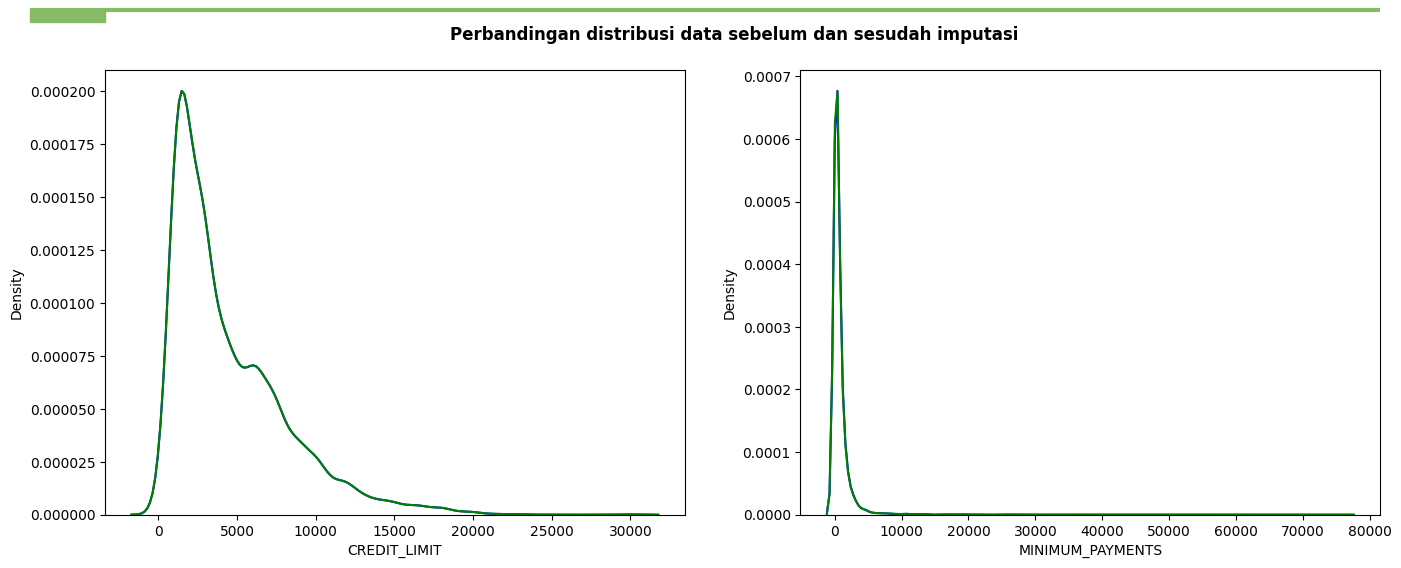

In [ ]:
# inisialisasi plot
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# adjust subplot
plt.subplots_adjust(left=0.05, top=1)

# garis lurus dan bentuk persegi panjang di atas
fig.add_artist(lines.Line2D([0, 0.9], [1.12, 1.12], lw=3, color=COLOR, solid_capstyle="butt"))
fig.add_artist(patches.Rectangle((0, 1.095), 0.05, 0.025, color=COLOR))

# judul grafik
fig.text(0.28, 1.06, "Perbandingan distribusi data sebelum dan sesudah imputasi", fontsize=12, fontweight="bold")

# display grafik CREDIT_LIMIT
sns.distplot(data['CREDIT_LIMIT'], kde=True, hist=False, color='blue', ax=ax1) # sebelum imputasi
sns.distplot(imputed_data_preprocess['CREDIT_LIMIT'], kde=True, hist=False, color='green', ax=ax1) # sesudah imputasi

# display grafik MINIMUM_PAYMENTS
sns.distplot(data['MINIMUM_PAYMENTS'], kde=True, hist=False, color='blue', ax=ax2) # sebelum imputasi
sns.distplot(imputed_data_preprocess['MINIMUM_PAYMENTS'], kde=True, hist=False, color='green', ax=ax2) # sesudah imputasi

plt.show()

**Insight**:
- Berdasarkan grafik distribusi di atas, dapat dilihat bahwa setelah melakukan imputasi, distribusi data **masih sama dengan** sebelum melakukan imputasi

Melakukan uji statistik _Two Sample Kolmogorov-Smirnov Test_ untuk memperkuat analisa di atas dan melihat apakah distribusi data setelah dilakukan imputasi **berbeda atau sama** dengan distribusi data sebelum dilakukan imputasi berdasarkan nilai _pvalue_

Hipotesis:
- Ho : Distribusi data sebelum dilakukan imputasi = distribusi data setelah dilakukan imputasi
- H1 : Distribusi data sebelum dilakukan imputasi ≠ distribusi data setelah dilakukan imputasi

significance level (alpha) = 0.05

In [ ]:
result1 = []
col_missing = ['CREDIT_LIMIT', 'MINIMUM_PAYMENTS']
for col in col_missing:
    # membandingkan 
    stats1, pvalue1 = ks_2samp(data[col].dropna(), imputed_data_preprocess[col], alternative='two-sided')

    # check the hypothesis:
    # Menerima H0
    if pvalue1 > 0.05:
        result1.append({'kolom':col,'significance_level':0.05,'pvalue':pvalue1, 'distribusi sebelum & sesudah': 'distribusi data sama'})
        # print(f"pvalue: {pvalue1}. Jadi, kami punya cukup bukti untuk mengatakan bahwa {col} pada DataFrame SEBELUM and SESUDAH \x1B[3mhandling missing values\x1B[0m memiliki distribusi yang \x1b[31msama\x1b[0m")
    # Menolak H0
    else:
        result1.append({'kolom':col, 'significance_level':0.05, 'pvalue':pvalue1, 'distribusi sebelum & sesudah': 'distribusi data berbeda'})
        # print(f"pvalue: {pvalue1}. Jadi, kami punya cukup bukti untuk mengatakan bahwa {col} pada DataFrame SEBELUM and SESUDAH \x1B[3mhandling missing values\x1B[0m memiliki distribusi yang \x1b[31mberbeda\x1b[0m")

# display hasil uji statistik
pd.DataFrame(result1)

kolom  significance_level    pvalue distribusi sebelum & sesudah
0      CREDIT_LIMIT                0.05  1.000000         distribusi data sama
1  MINIMUM_PAYMENTS                0.05  0.457845         distribusi data sama

**_Insight_**:
- Setelah melakukan imputasi menggunakan KNNImputer, distribusi data **masih sama dengan** ketika sebelum melakukan imputasi

#### **_SUMMARY PREPROCESSING_**:
- Mengganti nilai CASH_ADVANCE_FREQUENCY yang lebih dari 1 menjadi 1
- Melakukan _drop_ CUST_ID, karena tidak memberikan informasi mengenai bagaimana perilaku nasabah jika digunakan pada proses selanjutnya
- Melakukan _handling missing values_ pada kolom CREDIT_LIMIT dan MINIMUM_PAYMENTS menggunakan KNNImputer. Distribusi data masih sama baik sebelum melakukan _handling missing values_ maupun setelah melakukan _handling missing values_. Oleh karena itu _handling missing values_ sudah anggap benar
- **Data sudah siap digunakan untuk proses selanjutnya**

In [ ]:
# save cleaned dataset
# imputed_data_preprocess.to_csv("../data/processed/clean_cc_data.csv", index=False)

---------
---------